# Elo world 😁

First lets do some EDA in order to understand the data we are working on:
(Thanks to https://www.kaggle.com/chocozzz/simple-data-exploration-with-python-lb-3-764/code)

In [2]:
# Loading packages
import pandas as pd #Analysis 
import matplotlib.pyplot as plt #Visulization
import seaborn as sns #Visulization
import numpy as np #Analysis 
from scipy.stats import norm #Analysis 
from sklearn.preprocessing import StandardScaler #Analysis 
from scipy import stats #Analysis 
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
import gc


In [3]:
import os
print(os.listdir("./all"))

['Data_Dictionary.xlsx', 'historical_transactions.csv', 'merchants.csv', 'new_merchant_transactions.csv', 'sample_submission.csv', 'test.csv', 'test_new.csv', 'train.csv', 'train_new.csv']


- train.csv - the training set
- test.csv - the test set
- sample_submission.csv - a sample submission file in the correct format - contains all card_ids you are expected to predict for.
- historical_transactions.csv - up to 3 months' worth of historical transactions for each card_id
- merchants.csv - additional information about all merchants / merchant_ids in the dataset.
- new_merchant_transactions.csv - two months' worth of data for each card_id containing ALL purchases that card_id made at merchant_ids that were not visited in the historical data.

In [49]:
train = pd.read_csv("./all/train.csv", parse_dates=["first_active_month"])
print("shape of train : ",train.shape)

shape of train :  (201917, 6)


In [41]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


- first_active_month : ''YYYY-MM', month of first purchase
- feature_1,2,3 : Anonymized card categorical feature
- target : Loyalty numerical score calculated 2 months after historical and evaluation period

In [42]:
test = pd.read_csv("./all/test.csv", parse_dates=["first_active_month"])
print("shape of test : ",test.shape)

shape of test :  (123623, 5)


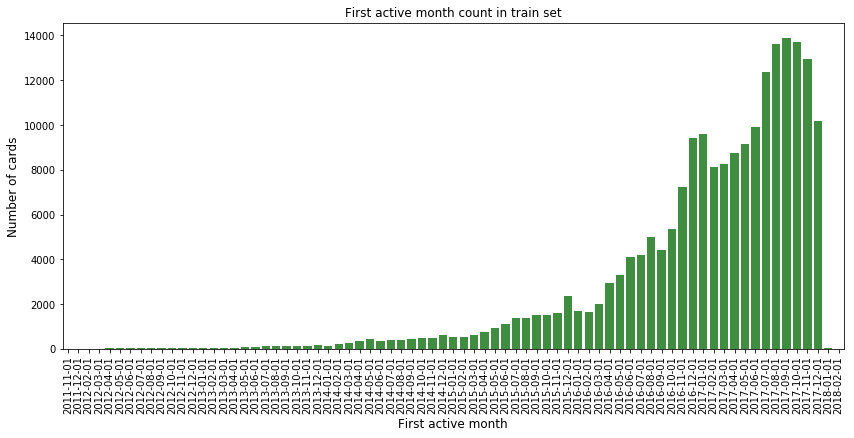

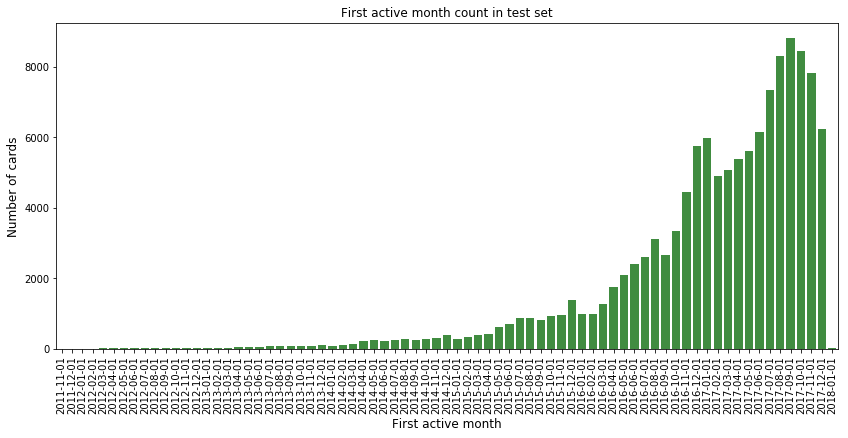

In [7]:
# Code in https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-elo
# SRK - Simple Exploration Notebook 

cnt_srs = train['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title("First active month count in train set")
plt.show()

cnt_srs = test['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title("First active month count in test set")
plt.show()

We can see that the test set and train set distribute similiar in First Active Month feature

Lets Explore the target:

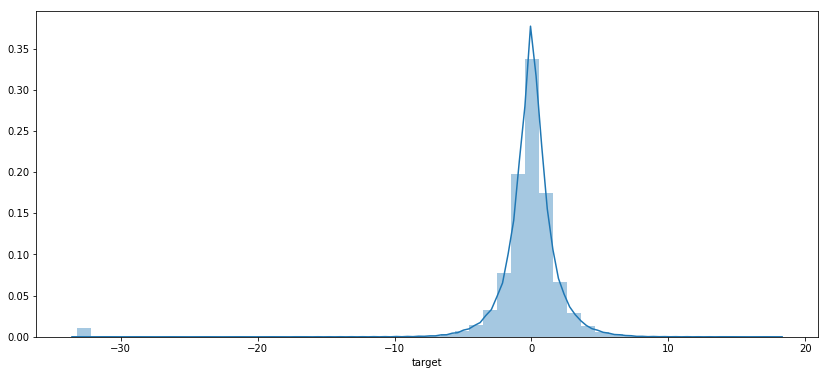

In [8]:
#histogram
f, ax = plt.subplots(figsize=(14, 6))
sns.distplot(train['target'])

We see that the data is distributed quite normally besides the small peak at the end, we'll adress these values as outliers and count how much of them we have in our data

In [12]:
outliers = train.loc[train['target']< -30]
outliers.shape 

(2207, 6)

In [13]:
percentOfOutliers = len(outliers) / len(train)
percentOfOutliers

0.010930233709890698

So one percent of our data are outliers and dont distibute normally like the rest of the data.
This will probably require special treatment, either removing them or modeling them. <br>
Lets explore how our train features distribute in outliers and non-outliers

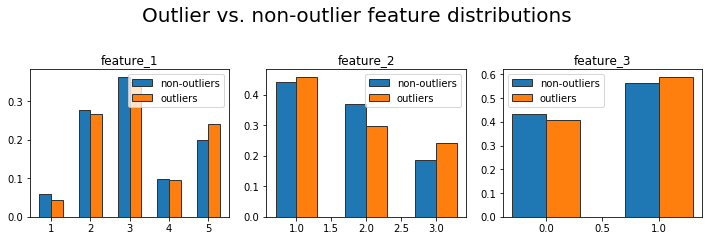

In [14]:
non_outliers = train.loc[train['target'] >= -30]

plt.figure(figsize=[10,5])
plt.suptitle('Outlier vs. non-outlier feature distributions', fontsize=20, y=1.1)

for num, col in enumerate(['feature_1', 'feature_2', 'feature_3']):
    plt.subplot(2, 3, num+1)
    v_c = non_outliers[col].value_counts() / non_outliers.shape[0]
    plt.bar(v_c.index, v_c, label=('non-outliers'), align='edge', width=-0.3, edgecolor=[0.2]*3)
    v_c = outliers[col].value_counts() / outliers.shape[0]
    plt.bar(v_c.index, v_c, label=('outliers'), align='edge', width=0.3, edgecolor=[0.2]*3)
    plt.title(col)
    plt.legend()

plt.tight_layout()
plt.show()



We can see some differences but they dont seem very significant, can be iteresting to let a model train on them and see what it can find

## Playing with LB

At that point we decided to play a little with submitting hand writen values to the competition in order to get some more insights about how the real test set is composed.

So First we tried to submit 0 as loyalty prediction for all which gave s rmse of 3.952, not bad at all considering at point of writing the rmse of 1st in LB is: 3.655.

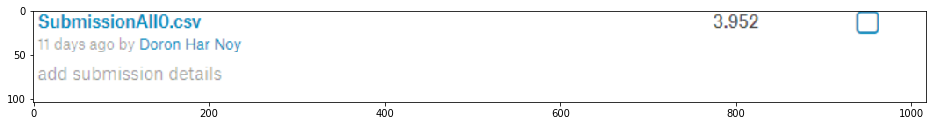

In [232]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(16,9))
img=mpimg.imread('./Pics/All0.PNG')
imgplot = plt.imshow(img)
plt.show()

After that we decided to play a bit more, what will happen if we will submit the mean of the data or the mean without outliers.

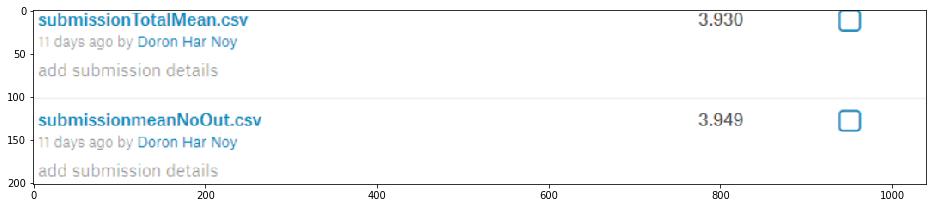

In [234]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(16,9))
img=mpimg.imread('./Pics/sub2.PNG')
imgplot = plt.imshow(img)
plt.show()

Interesting, so we can say for sure that the outlier data is playing a rule over here as the mean with the outlier data yields a better score.<br>
Umm, maybe submit all as outlier (loyalty score of -33.219281).

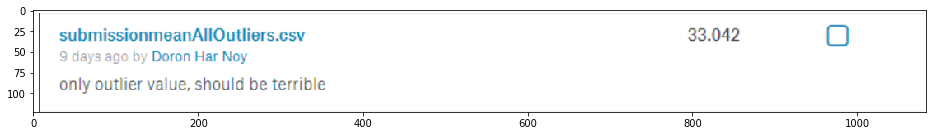

In [235]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(16,9))
img=mpimg.imread('./Pics/allout.PNG')
imgplot = plt.imshow(img)
plt.show()

Expected, but worth a try.

We continued researching that area and found the following topic in the discussion panel of the competion:
https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/74519

Lets reproduce What is shown there

In [6]:
from sklearn.metrics import mean_squared_error

target = train.target.values
rmse = np.sqrt(mean_squared_error(target, np.zeros(train.shape[0])))    # returns 3.8705589161316296
print(f'rmse of train against 0s: {rmse}')

rmse of train against 0s: 3.8705589161316296


In [7]:
target[target > -33] = 0
rmse = np.sqrt(mean_squared_error(target, np.zeros(train.shape[0])))  
print(f'rmse of only outliers in train against 0s: {rmse}')

rmse of only outliers in train against 0s: 3.4730013468168988


We see that in the train dataset these outliers are causing most of the rmse.

One reasonable thought that could arrise after this little experiement is that outliers could be one of the main purposes of this competition.<br>
Maybe it could represent users who commited some crime or  fraud.<br>
Another idea was maybe all users in the outlier set has done something 0 times, like spending 0 money with that credit card,  


# Best Model

For the best model we decided on combining predictions from the following models:

1. Model Trained on Extracted features predicting loyalty for all training set <br>
2. Model Trained on Extracted features predicting loyalty for training set without outliers<br>
3. Model Trained to find outlier probability <br>

The flow will be combining results from model1 and model2 by the probability in model3 while holding the tought that if the classifier is good enough, the LB score will have a big breakthrough.

## 1. Model Trained on Extracted features predicting loyalty for all training set 

model 1 and 2 are inspired from the notebook:
https://www.kaggle.com/ashishpatel26/lightgbm-gbdt-rf-baysian-ridge-reg-lb-3-61



In [113]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import BayesianRidge
warnings.simplefilter(action='ignore', category=FutureWarning)
import gc

In [114]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [115]:
new_transactions = pd.read_csv('./all/new_merchant_transactions.csv', parse_dates=['purchase_date'])
historical_transactions = pd.read_csv('./all/historical_transactions.csv', parse_dates=['purchase_date'])

def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

historical_transactions = binarize(historical_transactions)
new_transactions = binarize(new_transactions)

In [116]:
%%time
def read_data(input_file):
    df = pd.read_csv(input_file)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days
    return df

train = read_data('./all/train.csv')
test = read_data('./all/test.csv')

target = train['target']
del train['target']
gc.collect()

NameError: name 'datetime' is not defined

## Feature Engineering

In [117]:
%%time
historical_transactions = pd.get_dummies(historical_transactions, columns=['category_2', 'category_3'])
new_transactions = pd.get_dummies(new_transactions, columns=['category_2', 'category_3'])

historical_transactions = reduce_mem_usage(historical_transactions)
new_transactions = reduce_mem_usage(new_transactions)

agg_fun = {'authorized_flag': ['sum', 'mean']}
auth_mean = historical_transactions.groupby(['card_id']).agg(agg_fun)
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.reset_index(inplace=True)

authorized_transactions = historical_transactions[historical_transactions['authorized_flag'] == 1]
historical_transactions = historical_transactions[historical_transactions['authorized_flag'] == 0]
gc.collect()

Mem. usage decreased to 1304.89 Mb (54.8% reduction)
Mem. usage decreased to 84.24 Mb (56.7% reduction)
Wall time: 1min 32s


In [118]:
%%time
historical_transactions['purchase_month'] = historical_transactions['purchase_date'].dt.month
authorized_transactions['purchase_month'] = authorized_transactions['purchase_date'].dt.month
new_transactions['purchase_month'] = new_transactions['purchase_date'].dt.month
gc.collect()

Wall time: 2.94 s


In [119]:
%%time
def aggregate_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
        'category_1': ['sum', 'mean'],
        'category_2_1.0': ['mean'],
        'category_2_2.0': ['mean'],
        'category_2_3.0': ['mean'],
        'category_2_4.0': ['mean'],
        'category_2_5.0': ['mean'],
        'category_3_A': ['mean'],
        'category_3_B': ['mean'],
        'category_3_C': ['mean'],
        'merchant_id': ['nunique'],
        'merchant_category_id': ['nunique'],
        'state_id': ['nunique'],
        'city_id': ['nunique'],
        'subsector_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_month': ['mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp, 'min', 'max'],
        'month_lag': ['min', 'max']
        }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

gc.collect()

Wall time: 95.7 ms


In [120]:
%%time
history = aggregate_transactions(historical_transactions)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]
history[:5]
gc.collect()

Wall time: 44.3 s


In [121]:
%%time
authorized = aggregate_transactions(authorized_transactions)
authorized.columns = ['auth_' + c if c != 'card_id' else c for c in authorized.columns]
authorized[:5]
gc.collect()

Wall time: 1min 53s


In [122]:
%%time
new = aggregate_transactions(new_transactions)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]
new[:5]
gc.collect()

Wall time: 47.4 s


In [123]:
%%time
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group

final_group =  aggregate_per_month(historical_transactions) 
final_group[:10]
gc.collect()

Wall time: 6.91 s


In [124]:
%%time
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

train = pd.merge(train, authorized, on='card_id', how='left')
test = pd.merge(test, authorized, on='card_id', how='left')

train = pd.merge(train, new, on='card_id', how='left')
test = pd.merge(test, new, on='card_id', how='left')

train = pd.merge(train, final_group, on='card_id', how='left')
test = pd.merge(test, final_group, on='card_id', how='left')

train = pd.merge(train, auth_mean, on='card_id', how='left')
test = pd.merge(test, auth_mean, on='card_id', how='left')

print("Train Shape:", train.shape)
print("Test Shape:", test.shape)
gc.collect()

Train Shape: (201917, 139)
Test Shape: (123623, 138)
Wall time: 7.37 s


In [125]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = [c for c in features if 'feature_' in c]

## LightGBM

In [14]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "nthread": 4,
         "verbosity": -1}

In [15]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0


C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.73675	valid_1's rmse: 3.79933
[200]	training's rmse: 3.67453	valid_1's rmse: 3.7583
[300]	training's rmse: 3.63157	valid_1's rmse: 3.73585
[400]	training's rmse: 3.59773	valid_1's rmse: 3.72296
[500]	training's rmse: 3.57003	valid_1's rmse: 3.71418
[600]	training's rmse: 3.54626	valid_1's rmse: 3.70845
[700]	training's rmse: 3.52563	valid_1's rmse: 3.70372
[800]	training's rmse: 3.50718	valid_1's rmse: 3.70026
[900]	training's rmse: 3.49079	valid_1's rmse: 3.69714
[1000]	training's rmse: 3.47527	valid_1's rmse: 3.69466
[1100]	training's rmse: 3.46122	valid_1's rmse: 3.69272
[1200]	training's rmse: 3.44801	valid_1's rmse: 3.69142
[1300]	training's rmse: 3.43549	valid_1's rmse: 3.69052
[1400]	training's rmse: 3.42361	valid_1's rmse: 3.6895
[1500]	training's rmse: 3.41276	valid_1's rmse: 3.6887
[1600]	training's rmse: 3.40228	valid_1's rmse: 3.68823
[1700]	training's rmse: 3.39197	valid_1's rmse: 3.687

C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.7535	valid_1's rmse: 3.72902
[200]	training's rmse: 3.68959	valid_1's rmse: 3.69264
[300]	training's rmse: 3.64496	valid_1's rmse: 3.67412
[400]	training's rmse: 3.61067	valid_1's rmse: 3.66215
[500]	training's rmse: 3.58184	valid_1's rmse: 3.65457
[600]	training's rmse: 3.55767	valid_1's rmse: 3.64899
[700]	training's rmse: 3.5369	valid_1's rmse: 3.64485
[800]	training's rmse: 3.51923	valid_1's rmse: 3.64148
[900]	training's rmse: 3.50283	valid_1's rmse: 3.63878
[1000]	training's rmse: 3.4876	valid_1's rmse: 3.63662
[1100]	training's rmse: 3.47331	valid_1's rmse: 3.635
[1200]	training's rmse: 3.46	valid_1's rmse: 3.63376
[1300]	training's rmse: 3.44758	valid_1's rmse: 3.6325
[1400]	training's rmse: 3.43555	valid_1's rmse: 3.6316
[1500]	training's rmse: 3.4242	valid_1's rmse: 3.63097
[1600]	training's rmse: 3.41364	valid_1's rmse: 3.63018
[1700]	training's rmse: 3.40342	valid_1's rmse: 3.62966
[1800

C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.75771	valid_1's rmse: 3.70457
[200]	training's rmse: 3.69295	valid_1's rmse: 3.66962
[300]	training's rmse: 3.64849	valid_1's rmse: 3.65152
[400]	training's rmse: 3.61451	valid_1's rmse: 3.63981
[500]	training's rmse: 3.58712	valid_1's rmse: 3.63173
[600]	training's rmse: 3.56329	valid_1's rmse: 3.62623
[700]	training's rmse: 3.54283	valid_1's rmse: 3.62217
[800]	training's rmse: 3.52463	valid_1's rmse: 3.61896
[900]	training's rmse: 3.50789	valid_1's rmse: 3.61651
[1000]	training's rmse: 3.49293	valid_1's rmse: 3.61473
[1100]	training's rmse: 3.47906	valid_1's rmse: 3.61361
[1200]	training's rmse: 3.46554	valid_1's rmse: 3.61236
[1300]	training's rmse: 3.45314	valid_1's rmse: 3.61138
[1400]	training's rmse: 3.4416	valid_1's rmse: 3.61072
[1500]	training's rmse: 3.43007	valid_1's rmse: 3.61005
[1600]	training's rmse: 3.41899	valid_1's rmse: 3.60976
[1700]	training's rmse: 3.40856	valid_1's rmse: 3.6

C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.71146	valid_1's rmse: 3.89533
[200]	training's rmse: 3.64935	valid_1's rmse: 3.85285
[300]	training's rmse: 3.60529	valid_1's rmse: 3.83033
[400]	training's rmse: 3.57011	valid_1's rmse: 3.81776
[500]	training's rmse: 3.54184	valid_1's rmse: 3.81023
[600]	training's rmse: 3.5172	valid_1's rmse: 3.80553
[700]	training's rmse: 3.49663	valid_1's rmse: 3.80182
[800]	training's rmse: 3.47795	valid_1's rmse: 3.79867
[900]	training's rmse: 3.46135	valid_1's rmse: 3.79694
[1000]	training's rmse: 3.4455	valid_1's rmse: 3.79471
[1100]	training's rmse: 3.43117	valid_1's rmse: 3.79368
[1200]	training's rmse: 3.41795	valid_1's rmse: 3.79237
[1300]	training's rmse: 3.40546	valid_1's rmse: 3.79177
[1400]	training's rmse: 3.39332	valid_1's rmse: 3.79112
[1500]	training's rmse: 3.38204	valid_1's rmse: 3.79056
[1600]	training's rmse: 3.37134	valid_1's rmse: 3.78984
[1700]	training's rmse: 3.36101	valid_1's rmse: 3.78

C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.75346	valid_1's rmse: 3.7179
[200]	training's rmse: 3.68749	valid_1's rmse: 3.6846
[300]	training's rmse: 3.64242	valid_1's rmse: 3.66844
[400]	training's rmse: 3.60773	valid_1's rmse: 3.65855
[500]	training's rmse: 3.57943	valid_1's rmse: 3.65253
[600]	training's rmse: 3.55559	valid_1's rmse: 3.64772
[700]	training's rmse: 3.53523	valid_1's rmse: 3.64399
[800]	training's rmse: 3.51701	valid_1's rmse: 3.64102
[900]	training's rmse: 3.50037	valid_1's rmse: 3.63907
[1000]	training's rmse: 3.4856	valid_1's rmse: 3.63719
[1100]	training's rmse: 3.47157	valid_1's rmse: 3.63574
[1200]	training's rmse: 3.45861	valid_1's rmse: 3.63442
[1300]	training's rmse: 3.44568	valid_1's rmse: 3.63333
[1400]	training's rmse: 3.43417	valid_1's rmse: 3.63253
[1500]	training's rmse: 3.42319	valid_1's rmse: 3.63169
[1600]	training's rmse: 3.41283	valid_1's rmse: 3.6314
[1700]	training's rmse: 3.40243	valid_1's rmse: 3.6310

## LightGBM-1 with Repeated kfold approach

#### RepeatedKFold repeats K-Fold n times. It can be used when one requires to run KFold n times, producing different splits in each repetition.

In [17]:
lgbparam = {'num_leaves': 31,
            'boosting_type': 'rf',
             'min_data_in_leaf': 30, 
             'objective':'regression',
             'max_depth': -1,
             'learning_rate': 0.01,
             "min_child_samples": 20,
             "boosting": "gbdt",
             "feature_fraction": 0.9,
             "bagging_freq": 1,
             "bagging_fraction": 0.9 ,
             "bagging_seed": 11,
             "metric": 'rmse',
             "lambda_l1": 0.1,
             "verbosity": -1,
             "nthread": 4,
             "random_state": 4590}

In [18]:
from sklearn.model_selection import RepeatedKFold
folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4520)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=categorical_feats)

    num_round = 11000
    clf = lgb.train(lgbparam, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_lgb += clf.predict(test[features], num_iteration=clf.best_iteration) / (5 * 2)

print("CV score: {:<8.5f}".format(mean_squared_error(oof_lgb, target)**0.5))

fold n°0


C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.67318	valid_1's rmse: 3.74595
[200]	training's rmse: 3.59216	valid_1's rmse: 3.71949
[300]	training's rmse: 3.53748	valid_1's rmse: 3.70728
[400]	training's rmse: 3.49722	valid_1's rmse: 3.70178
[500]	training's rmse: 3.46457	valid_1's rmse: 3.69815
[600]	training's rmse: 3.43715	valid_1's rmse: 3.69616
[700]	training's rmse: 3.41309	valid_1's rmse: 3.69482
[800]	training's rmse: 3.39031	valid_1's rmse: 3.69416
[900]	training's rmse: 3.36873	valid_1's rmse: 3.69428
Early stopping, best iteration is:
[826]	training's rmse: 3.38473	valid_1's rmse: 3.69402
fold n°1


C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.70799	valid_1's rmse: 3.60903
[200]	training's rmse: 3.63021	valid_1's rmse: 3.57665
[300]	training's rmse: 3.57735	valid_1's rmse: 3.56223
[400]	training's rmse: 3.5378	valid_1's rmse: 3.55297
[500]	training's rmse: 3.50606	valid_1's rmse: 3.54763
[600]	training's rmse: 3.47866	valid_1's rmse: 3.54347
[700]	training's rmse: 3.45471	valid_1's rmse: 3.54099
[800]	training's rmse: 3.43253	valid_1's rmse: 3.53949
[900]	training's rmse: 3.41087	valid_1's rmse: 3.53908
[1000]	training's rmse: 3.39129	valid_1's rmse: 3.53836
[1100]	training's rmse: 3.37305	valid_1's rmse: 3.53782
[1200]	training's rmse: 3.35462	valid_1's rmse: 3.53751
[1300]	training's rmse: 3.33721	valid_1's rmse: 3.53714
[1400]	training's rmse: 3.32011	valid_1's rmse: 3.53698
[1500]	training's rmse: 3.30382	valid_1's rmse: 3.53698
[1600]	training's rmse: 3.28899	valid_1's rmse: 3.53676
[1700]	training's rmse: 3.27364	valid_1's rmse: 3.5

C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.63843	valid_1's rmse: 3.89346
[200]	training's rmse: 3.55939	valid_1's rmse: 3.86269
[300]	training's rmse: 3.50763	valid_1's rmse: 3.84852
[400]	training's rmse: 3.46923	valid_1's rmse: 3.84086
[500]	training's rmse: 3.43763	valid_1's rmse: 3.83638
[600]	training's rmse: 3.40943	valid_1's rmse: 3.83357
[700]	training's rmse: 3.38508	valid_1's rmse: 3.83156
[800]	training's rmse: 3.36155	valid_1's rmse: 3.8306
[900]	training's rmse: 3.34178	valid_1's rmse: 3.83006
[1000]	training's rmse: 3.32308	valid_1's rmse: 3.82936
[1100]	training's rmse: 3.30441	valid_1's rmse: 3.82868
[1200]	training's rmse: 3.28756	valid_1's rmse: 3.8285
[1300]	training's rmse: 3.27043	valid_1's rmse: 3.82844
Early stopping, best iteration is:
[1280]	training's rmse: 3.27397	valid_1's rmse: 3.82817
fold n°3


C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.68029	valid_1's rmse: 3.72178
[200]	training's rmse: 3.6015	valid_1's rmse: 3.69238
[300]	training's rmse: 3.54722	valid_1's rmse: 3.68047
[400]	training's rmse: 3.50836	valid_1's rmse: 3.67354
[500]	training's rmse: 3.47639	valid_1's rmse: 3.6696
[600]	training's rmse: 3.44779	valid_1's rmse: 3.66657
[700]	training's rmse: 3.42234	valid_1's rmse: 3.66512
[800]	training's rmse: 3.39988	valid_1's rmse: 3.66383
[900]	training's rmse: 3.37871	valid_1's rmse: 3.6628
[1000]	training's rmse: 3.35936	valid_1's rmse: 3.66217
[1100]	training's rmse: 3.34058	valid_1's rmse: 3.662
[1200]	training's rmse: 3.32309	valid_1's rmse: 3.66178
[1300]	training's rmse: 3.30541	valid_1's rmse: 3.6622
Early stopping, best iteration is:
[1250]	training's rmse: 3.31488	valid_1's rmse: 3.66166
fold n°4


C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.68914	valid_1's rmse: 3.68913
[200]	training's rmse: 3.61125	valid_1's rmse: 3.65393
[300]	training's rmse: 3.55897	valid_1's rmse: 3.6392
[400]	training's rmse: 3.52016	valid_1's rmse: 3.63028
[500]	training's rmse: 3.48781	valid_1's rmse: 3.62495
[600]	training's rmse: 3.46129	valid_1's rmse: 3.6204
[700]	training's rmse: 3.43678	valid_1's rmse: 3.61794
[800]	training's rmse: 3.41463	valid_1's rmse: 3.61629
[900]	training's rmse: 3.39329	valid_1's rmse: 3.61533
[1000]	training's rmse: 3.37381	valid_1's rmse: 3.61439
[1100]	training's rmse: 3.35735	valid_1's rmse: 3.61409
Early stopping, best iteration is:
[1079]	training's rmse: 3.36077	valid_1's rmse: 3.61378
fold n°5


C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.66242	valid_1's rmse: 3.78435
[200]	training's rmse: 3.58192	valid_1's rmse: 3.75821
[300]	training's rmse: 3.52974	valid_1's rmse: 3.74946
[400]	training's rmse: 3.49032	valid_1's rmse: 3.74265
[500]	training's rmse: 3.45673	valid_1's rmse: 3.73846
[600]	training's rmse: 3.42833	valid_1's rmse: 3.73604
[700]	training's rmse: 3.4028	valid_1's rmse: 3.73369
[800]	training's rmse: 3.38076	valid_1's rmse: 3.73218
[900]	training's rmse: 3.35929	valid_1's rmse: 3.73199
[1000]	training's rmse: 3.33958	valid_1's rmse: 3.7317
[1100]	training's rmse: 3.3222	valid_1's rmse: 3.73167
Early stopping, best iteration is:
[1086]	training's rmse: 3.32453	valid_1's rmse: 3.73148
fold n°6


C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.67855	valid_1's rmse: 3.72279
[200]	training's rmse: 3.5986	valid_1's rmse: 3.69428
[300]	training's rmse: 3.54499	valid_1's rmse: 3.68336
[400]	training's rmse: 3.50532	valid_1's rmse: 3.67554
[500]	training's rmse: 3.47375	valid_1's rmse: 3.67011
[600]	training's rmse: 3.44738	valid_1's rmse: 3.66676
[700]	training's rmse: 3.4229	valid_1's rmse: 3.66448
[800]	training's rmse: 3.401	valid_1's rmse: 3.66306
[900]	training's rmse: 3.38029	valid_1's rmse: 3.66205
[1000]	training's rmse: 3.36101	valid_1's rmse: 3.66113
[1100]	training's rmse: 3.34191	valid_1's rmse: 3.6606
[1200]	training's rmse: 3.32385	valid_1's rmse: 3.66022
[1300]	training's rmse: 3.30705	valid_1's rmse: 3.6603
Early stopping, best iteration is:
[1263]	training's rmse: 3.31298	valid_1's rmse: 3.66
fold n°7


C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.67568	valid_1's rmse: 3.75187
[200]	training's rmse: 3.59841	valid_1's rmse: 3.71507
[300]	training's rmse: 3.54626	valid_1's rmse: 3.70036
[400]	training's rmse: 3.50739	valid_1's rmse: 3.69313
[500]	training's rmse: 3.47619	valid_1's rmse: 3.6886
[600]	training's rmse: 3.44901	valid_1's rmse: 3.68586
[700]	training's rmse: 3.4254	valid_1's rmse: 3.68423
[800]	training's rmse: 3.40287	valid_1's rmse: 3.68288
[900]	training's rmse: 3.38184	valid_1's rmse: 3.682
[1000]	training's rmse: 3.36163	valid_1's rmse: 3.68112
Early stopping, best iteration is:
[990]	training's rmse: 3.3637	valid_1's rmse: 3.68097
fold n°8


C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.68263	valid_1's rmse: 3.71028
[200]	training's rmse: 3.60346	valid_1's rmse: 3.67986
[300]	training's rmse: 3.54947	valid_1's rmse: 3.66641
[400]	training's rmse: 3.50911	valid_1's rmse: 3.66053
[500]	training's rmse: 3.47634	valid_1's rmse: 3.65722
[600]	training's rmse: 3.44867	valid_1's rmse: 3.65537
[700]	training's rmse: 3.42258	valid_1's rmse: 3.65414
[800]	training's rmse: 3.4	valid_1's rmse: 3.65305
[900]	training's rmse: 3.37817	valid_1's rmse: 3.65282
Early stopping, best iteration is:
[873]	training's rmse: 3.38373	valid_1's rmse: 3.6525
fold n°9


C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.69173	valid_1's rmse: 3.68395
[200]	training's rmse: 3.61341	valid_1's rmse: 3.64948
[300]	training's rmse: 3.56051	valid_1's rmse: 3.63389
[400]	training's rmse: 3.52102	valid_1's rmse: 3.62503
[500]	training's rmse: 3.48951	valid_1's rmse: 3.61954
[600]	training's rmse: 3.46347	valid_1's rmse: 3.61626
[700]	training's rmse: 3.43919	valid_1's rmse: 3.61364
[800]	training's rmse: 3.41756	valid_1's rmse: 3.61229
[900]	training's rmse: 3.39775	valid_1's rmse: 3.61091
[1000]	training's rmse: 3.37766	valid_1's rmse: 3.60958
[1100]	training's rmse: 3.35847	valid_1's rmse: 3.60871
[1200]	training's rmse: 3.34168	valid_1's rmse: 3.6081
[1300]	training's rmse: 3.32465	valid_1's rmse: 3.60811
[1400]	training's rmse: 3.30737	valid_1's rmse: 3.60768
[1500]	training's rmse: 3.29118	valid_1's rmse: 3.60732
[1600]	training's rmse: 3.27592	valid_1's rmse: 3.60683
Early stopping, best iteration is:
[1588]	training'

In [25]:
sample_submission = pd.read_csv('./all/sample_submission.csv')
sample_submission['target'] = predictions * 0.5 + predictions_lgb * 0.5
sample_submission.to_csv("./Submissions/Model1.csv", index = False)

## 2. Model Trained on Extracted features predicting loyalty for training set without outliers

In order to train on model without outliers we have to find them and ignore them

In [35]:
train['outliers'] = 0
train.loc[train['target'] < -30, 'outliers'] = 1

In [37]:
trainNoOut = train.loc[train['outliers'] == 0]

199710

In [39]:
targetNoOut = trainNoOut['target']
del trainNoOut['target']
del trainNoOut['outliers']
gc.collect()

35

In this point we have the train dataset without 1% outliers in it and the targets for all training set

In [44]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(trainNoOut))
predictions_noOut = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(trainNoOut.values, targetNoOut.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(trainNoOut.iloc[trn_idx][features], label=targetNoOut.iloc[trn_idx], categorical_feature=categorical_feats)
    val_data = lgb.Dataset(trainNoOut.iloc[val_idx][features], label=targetNoOut.iloc[val_idx], categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(trainNoOut.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_noOut += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, targetNoOut)**0.5))

fold n°0


C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 1.64203	valid_1's rmse: 1.65017
[200]	training's rmse: 1.60628	valid_1's rmse: 1.61779
[300]	training's rmse: 1.58702	valid_1's rmse: 1.60122
[400]	training's rmse: 1.5751	valid_1's rmse: 1.59142
[500]	training's rmse: 1.56665	valid_1's rmse: 1.58511
[600]	training's rmse: 1.56009	valid_1's rmse: 1.58076
[700]	training's rmse: 1.5547	valid_1's rmse: 1.57744
[800]	training's rmse: 1.55015	valid_1's rmse: 1.57507
[900]	training's rmse: 1.54611	valid_1's rmse: 1.57317
[1000]	training's rmse: 1.54249	valid_1's rmse: 1.5717
[1100]	training's rmse: 1.53922	valid_1's rmse: 1.57052
[1200]	training's rmse: 1.5362	valid_1's rmse: 1.56962
[1300]	training's rmse: 1.53337	valid_1's rmse: 1.56897
[1400]	training's rmse: 1.53072	valid_1's rmse: 1.5684
[1500]	training's rmse: 1.52821	valid_1's rmse: 1.568
[1600]	training's rmse: 1.52573	valid_1's rmse: 1.56761
[1700]	training's rmse: 1.52345	valid_1's rmse: 1.56734
[

C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 1.64269	valid_1's rmse: 1.64867
[200]	training's rmse: 1.60719	valid_1's rmse: 1.61537
[300]	training's rmse: 1.58805	valid_1's rmse: 1.59824
[400]	training's rmse: 1.57601	valid_1's rmse: 1.58836
[500]	training's rmse: 1.56753	valid_1's rmse: 1.58216
[600]	training's rmse: 1.56097	valid_1's rmse: 1.57783
[700]	training's rmse: 1.55549	valid_1's rmse: 1.5746
[800]	training's rmse: 1.55093	valid_1's rmse: 1.57222
[900]	training's rmse: 1.54691	valid_1's rmse: 1.57042
[1000]	training's rmse: 1.54325	valid_1's rmse: 1.56898
[1100]	training's rmse: 1.53997	valid_1's rmse: 1.56792
[1200]	training's rmse: 1.53695	valid_1's rmse: 1.56706
[1300]	training's rmse: 1.53417	valid_1's rmse: 1.56644
[1400]	training's rmse: 1.53152	valid_1's rmse: 1.56592
[1500]	training's rmse: 1.52902	valid_1's rmse: 1.56555
[1600]	training's rmse: 1.52665	valid_1's rmse: 1.5652
[1700]	training's rmse: 1.52432	valid_1's rmse: 1.56

C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 1.64771	valid_1's rmse: 1.62801
[200]	training's rmse: 1.61225	valid_1's rmse: 1.59422
[300]	training's rmse: 1.59308	valid_1's rmse: 1.57694
[400]	training's rmse: 1.58109	valid_1's rmse: 1.56713
[500]	training's rmse: 1.57271	valid_1's rmse: 1.56085
[600]	training's rmse: 1.56622	valid_1's rmse: 1.55649
[700]	training's rmse: 1.56082	valid_1's rmse: 1.55316
[800]	training's rmse: 1.55623	valid_1's rmse: 1.55059
[900]	training's rmse: 1.55225	valid_1's rmse: 1.5487
[1000]	training's rmse: 1.54868	valid_1's rmse: 1.54722
[1100]	training's rmse: 1.54542	valid_1's rmse: 1.54605
[1200]	training's rmse: 1.5424	valid_1's rmse: 1.54516
[1300]	training's rmse: 1.5396	valid_1's rmse: 1.54441
[1400]	training's rmse: 1.53697	valid_1's rmse: 1.54382
[1500]	training's rmse: 1.53451	valid_1's rmse: 1.54333
[1600]	training's rmse: 1.53214	valid_1's rmse: 1.54293
[1700]	training's rmse: 1.52988	valid_1's rmse: 1.542

C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 1.64295	valid_1's rmse: 1.64844
[200]	training's rmse: 1.60749	valid_1's rmse: 1.61475
[300]	training's rmse: 1.58821	valid_1's rmse: 1.59764
[400]	training's rmse: 1.57619	valid_1's rmse: 1.58763
[500]	training's rmse: 1.56778	valid_1's rmse: 1.58128
[600]	training's rmse: 1.56124	valid_1's rmse: 1.5768
[700]	training's rmse: 1.55579	valid_1's rmse: 1.57352
[800]	training's rmse: 1.55118	valid_1's rmse: 1.57111
[900]	training's rmse: 1.54717	valid_1's rmse: 1.56929
[1000]	training's rmse: 1.54354	valid_1's rmse: 1.56786
[1100]	training's rmse: 1.54032	valid_1's rmse: 1.56676
[1200]	training's rmse: 1.53739	valid_1's rmse: 1.56592
[1300]	training's rmse: 1.53462	valid_1's rmse: 1.56521
[1400]	training's rmse: 1.53204	valid_1's rmse: 1.56472
[1500]	training's rmse: 1.52952	valid_1's rmse: 1.56433
[1600]	training's rmse: 1.52717	valid_1's rmse: 1.56404
[1700]	training's rmse: 1.52493	valid_1's rmse: 1.5

C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 1.64181	valid_1's rmse: 1.65248
[200]	training's rmse: 1.60618	valid_1's rmse: 1.61867
[300]	training's rmse: 1.58703	valid_1's rmse: 1.6013
[400]	training's rmse: 1.57518	valid_1's rmse: 1.59126
[500]	training's rmse: 1.56679	valid_1's rmse: 1.58478
[600]	training's rmse: 1.56035	valid_1's rmse: 1.58039
[700]	training's rmse: 1.55493	valid_1's rmse: 1.57699
[800]	training's rmse: 1.55034	valid_1's rmse: 1.57452
[900]	training's rmse: 1.5463	valid_1's rmse: 1.57245
[1000]	training's rmse: 1.54269	valid_1's rmse: 1.57084
[1100]	training's rmse: 1.53945	valid_1's rmse: 1.56961
[1200]	training's rmse: 1.53651	valid_1's rmse: 1.56871
[1300]	training's rmse: 1.53369	valid_1's rmse: 1.568
[1400]	training's rmse: 1.53105	valid_1's rmse: 1.56744
[1500]	training's rmse: 1.52854	valid_1's rmse: 1.5669
[1600]	training's rmse: 1.52619	valid_1's rmse: 1.56654
[1700]	training's rmse: 1.52392	valid_1's rmse: 1.56619

In [45]:
from sklearn.model_selection import RepeatedKFold
folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4520)

oof_lgb = np.zeros(len(trainNoOut))
predictions_lgb_noOut = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(trainNoOut.values, targetNoOut.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(trainNoOut.iloc[trn_idx][features], label=targetNoOut.iloc[trn_idx], categorical_feature=categorical_feats)
    val_data = lgb.Dataset(trainNoOut.iloc[val_idx][features], label=targetNoOut.iloc[val_idx], categorical_feature=categorical_feats)

    num_round = 11000
    clf = lgb.train(lgbparam, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(trainNoOut.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_lgb_noOut += clf.predict(test[features], num_iteration=clf.best_iteration) / (5 * 2)

print("CV score: {:<8.5f}".format(mean_squared_error(oof_lgb, targetNoOut)**0.5))

fold n°0


C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.60706	valid_1's rmse: 1.61511
[200]	training's rmse: 1.57604	valid_1's rmse: 1.58825
[300]	training's rmse: 1.56114	valid_1's rmse: 1.57746
[400]	training's rmse: 1.55133	valid_1's rmse: 1.57189
[500]	training's rmse: 1.54375	valid_1's rmse: 1.56853
[600]	training's rmse: 1.53759	valid_1's rmse: 1.56635
[700]	training's rmse: 1.53216	valid_1's rmse: 1.56512
[800]	training's rmse: 1.52735	valid_1's rmse: 1.56433
[900]	training's rmse: 1.52279	valid_1's rmse: 1.56377
[1000]	training's rmse: 1.51868	valid_1's rmse: 1.56337
[1100]	training's rmse: 1.51476	valid_1's rmse: 1.56306
[1200]	training's rmse: 1.51096	valid_1's rmse: 1.56281
[1300]	training's rmse: 1.50716	valid_1's rmse: 1.56257
[1400]	training's rmse: 1.50351	valid_1's rmse: 1.56243
[1500]	training's rmse: 1.5	valid_1's rmse: 1.56223
[1600]	training's rmse: 1.4965	valid_1's rmse: 1.56212
[1700]	training's rmse: 1.49308	valid_1's rmse: 1.56205

C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.61031	valid_1's rmse: 1.60134
[200]	training's rmse: 1.5794	valid_1's rmse: 1.57392
[300]	training's rmse: 1.56435	valid_1's rmse: 1.56296
[400]	training's rmse: 1.55432	valid_1's rmse: 1.55731
[500]	training's rmse: 1.54664	valid_1's rmse: 1.55412
[600]	training's rmse: 1.54031	valid_1's rmse: 1.55243
[700]	training's rmse: 1.53474	valid_1's rmse: 1.55147
[800]	training's rmse: 1.52986	valid_1's rmse: 1.55099
[900]	training's rmse: 1.52532	valid_1's rmse: 1.55061
[1000]	training's rmse: 1.52099	valid_1's rmse: 1.55041
[1100]	training's rmse: 1.51686	valid_1's rmse: 1.55013
[1200]	training's rmse: 1.51305	valid_1's rmse: 1.54993
[1300]	training's rmse: 1.5092	valid_1's rmse: 1.54981
[1400]	training's rmse: 1.50538	valid_1's rmse: 1.54978
[1500]	training's rmse: 1.50182	valid_1's rmse: 1.54964
[1600]	training's rmse: 1.49819	valid_1's rmse: 1.54961
[1700]	training's rmse: 1.49475	valid_1's rmse: 1.54

C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.60953	valid_1's rmse: 1.60553
[200]	training's rmse: 1.57835	valid_1's rmse: 1.57922
[300]	training's rmse: 1.56339	valid_1's rmse: 1.56881
[400]	training's rmse: 1.55344	valid_1's rmse: 1.56334
[500]	training's rmse: 1.5457	valid_1's rmse: 1.56009
[600]	training's rmse: 1.5394	valid_1's rmse: 1.55808
[700]	training's rmse: 1.53404	valid_1's rmse: 1.5568
[800]	training's rmse: 1.52913	valid_1's rmse: 1.55588
[900]	training's rmse: 1.52474	valid_1's rmse: 1.55512
[1000]	training's rmse: 1.52048	valid_1's rmse: 1.5547
[1100]	training's rmse: 1.51647	valid_1's rmse: 1.55447
[1200]	training's rmse: 1.51266	valid_1's rmse: 1.55417
[1300]	training's rmse: 1.50874	valid_1's rmse: 1.55393
[1400]	training's rmse: 1.50513	valid_1's rmse: 1.55368
[1500]	training's rmse: 1.50154	valid_1's rmse: 1.55355
[1600]	training's rmse: 1.4982	valid_1's rmse: 1.55337
[1700]	training's rmse: 1.49479	valid_1's rmse: 1.55328

C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.60579	valid_1's rmse: 1.61853
[200]	training's rmse: 1.57429	valid_1's rmse: 1.59252
[300]	training's rmse: 1.55928	valid_1's rmse: 1.58251
[400]	training's rmse: 1.54931	valid_1's rmse: 1.57699
[500]	training's rmse: 1.54174	valid_1's rmse: 1.57377
[600]	training's rmse: 1.5354	valid_1's rmse: 1.57188
[700]	training's rmse: 1.52997	valid_1's rmse: 1.57078
[800]	training's rmse: 1.52502	valid_1's rmse: 1.57006
[900]	training's rmse: 1.52057	valid_1's rmse: 1.56953
[1000]	training's rmse: 1.51626	valid_1's rmse: 1.5691
[1100]	training's rmse: 1.51229	valid_1's rmse: 1.56883
[1200]	training's rmse: 1.50851	valid_1's rmse: 1.56863
[1300]	training's rmse: 1.50475	valid_1's rmse: 1.56842
[1400]	training's rmse: 1.50106	valid_1's rmse: 1.56816
[1500]	training's rmse: 1.49746	valid_1's rmse: 1.56804
[1600]	training's rmse: 1.4939	valid_1's rmse: 1.56793
[1700]	training's rmse: 1.4904	valid_1's rmse: 1.5678

C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.60634	valid_1's rmse: 1.61974
[200]	training's rmse: 1.5755	valid_1's rmse: 1.59146
[300]	training's rmse: 1.56058	valid_1's rmse: 1.57976
[400]	training's rmse: 1.5507	valid_1's rmse: 1.5736
[500]	training's rmse: 1.54313	valid_1's rmse: 1.5699
[600]	training's rmse: 1.53681	valid_1's rmse: 1.56767
[700]	training's rmse: 1.53132	valid_1's rmse: 1.56625
[800]	training's rmse: 1.52633	valid_1's rmse: 1.56548
[900]	training's rmse: 1.52183	valid_1's rmse: 1.56487
[1000]	training's rmse: 1.51753	valid_1's rmse: 1.56444
[1100]	training's rmse: 1.51355	valid_1's rmse: 1.56416
[1200]	training's rmse: 1.50982	valid_1's rmse: 1.56401
[1300]	training's rmse: 1.50612	valid_1's rmse: 1.56379
[1400]	training's rmse: 1.50256	valid_1's rmse: 1.56365
[1500]	training's rmse: 1.499	valid_1's rmse: 1.56342
[1600]	training's rmse: 1.49553	valid_1's rmse: 1.56333
[1700]	training's rmse: 1.4921	valid_1's rmse: 1.56315
[

C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.60619	valid_1's rmse: 1.61911
[200]	training's rmse: 1.57494	valid_1's rmse: 1.59237
[300]	training's rmse: 1.5598	valid_1's rmse: 1.58181
[400]	training's rmse: 1.54984	valid_1's rmse: 1.57645
[500]	training's rmse: 1.54218	valid_1's rmse: 1.57329
[600]	training's rmse: 1.53592	valid_1's rmse: 1.57123
[700]	training's rmse: 1.53048	valid_1's rmse: 1.57009
[800]	training's rmse: 1.52566	valid_1's rmse: 1.56932
[900]	training's rmse: 1.52129	valid_1's rmse: 1.56885
[1000]	training's rmse: 1.51712	valid_1's rmse: 1.56838
[1100]	training's rmse: 1.5132	valid_1's rmse: 1.56793
[1200]	training's rmse: 1.50932	valid_1's rmse: 1.56764
[1300]	training's rmse: 1.50557	valid_1's rmse: 1.56735
[1400]	training's rmse: 1.50199	valid_1's rmse: 1.56713
[1500]	training's rmse: 1.49849	valid_1's rmse: 1.56706
[1600]	training's rmse: 1.49501	valid_1's rmse: 1.56679
[1700]	training's rmse: 1.49154	valid_1's rmse: 1.56

C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.60905	valid_1's rmse: 1.60582
[200]	training's rmse: 1.57794	valid_1's rmse: 1.57976
[300]	training's rmse: 1.56305	valid_1's rmse: 1.56897
[400]	training's rmse: 1.55306	valid_1's rmse: 1.56308
[500]	training's rmse: 1.54548	valid_1's rmse: 1.55958
[600]	training's rmse: 1.53914	valid_1's rmse: 1.55734
[700]	training's rmse: 1.53366	valid_1's rmse: 1.556
[800]	training's rmse: 1.5287	valid_1's rmse: 1.55518
[900]	training's rmse: 1.52418	valid_1's rmse: 1.55458
[1000]	training's rmse: 1.51989	valid_1's rmse: 1.55421
[1100]	training's rmse: 1.51581	valid_1's rmse: 1.5539
[1200]	training's rmse: 1.51199	valid_1's rmse: 1.55382
[1300]	training's rmse: 1.50815	valid_1's rmse: 1.55364
[1400]	training's rmse: 1.50443	valid_1's rmse: 1.55346
[1500]	training's rmse: 1.50083	valid_1's rmse: 1.55335
[1600]	training's rmse: 1.49736	valid_1's rmse: 1.55325
[1700]	training's rmse: 1.49391	valid_1's rmse: 1.5532

C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.61006	valid_1's rmse: 1.60302
[200]	training's rmse: 1.57895	valid_1's rmse: 1.57595
[300]	training's rmse: 1.56379	valid_1's rmse: 1.5651
[400]	training's rmse: 1.55384	valid_1's rmse: 1.55961
[500]	training's rmse: 1.54623	valid_1's rmse: 1.55645
[600]	training's rmse: 1.53995	valid_1's rmse: 1.55451
[700]	training's rmse: 1.53446	valid_1's rmse: 1.55339
[800]	training's rmse: 1.5296	valid_1's rmse: 1.55272
[900]	training's rmse: 1.52513	valid_1's rmse: 1.55235
[1000]	training's rmse: 1.52094	valid_1's rmse: 1.55205
[1100]	training's rmse: 1.51697	valid_1's rmse: 1.55188
[1200]	training's rmse: 1.513	valid_1's rmse: 1.55155
[1300]	training's rmse: 1.50936	valid_1's rmse: 1.55136
[1400]	training's rmse: 1.50561	valid_1's rmse: 1.55121
[1500]	training's rmse: 1.50222	valid_1's rmse: 1.5512
[1600]	training's rmse: 1.49867	valid_1's rmse: 1.55102
[1700]	training's rmse: 1.49525	valid_1's rmse: 1.55094

C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.60423	valid_1's rmse: 1.62663
[200]	training's rmse: 1.57334	valid_1's rmse: 1.59911
[300]	training's rmse: 1.55852	valid_1's rmse: 1.58802
[400]	training's rmse: 1.54864	valid_1's rmse: 1.58206
[500]	training's rmse: 1.54117	valid_1's rmse: 1.57862
[600]	training's rmse: 1.53491	valid_1's rmse: 1.57639
[700]	training's rmse: 1.52952	valid_1's rmse: 1.57504
[800]	training's rmse: 1.52471	valid_1's rmse: 1.57416
[900]	training's rmse: 1.52027	valid_1's rmse: 1.57341
[1000]	training's rmse: 1.51613	valid_1's rmse: 1.57297
[1100]	training's rmse: 1.51214	valid_1's rmse: 1.57266
[1200]	training's rmse: 1.50824	valid_1's rmse: 1.57228
[1300]	training's rmse: 1.50458	valid_1's rmse: 1.57202
[1400]	training's rmse: 1.50102	valid_1's rmse: 1.57185
[1500]	training's rmse: 1.49742	valid_1's rmse: 1.57165
[1600]	training's rmse: 1.49393	valid_1's rmse: 1.57158
[1700]	training's rmse: 1.49052	valid_1's rmse: 1.

C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.60948	valid_1's rmse: 1.606
[200]	training's rmse: 1.5786	valid_1's rmse: 1.57892
[300]	training's rmse: 1.56365	valid_1's rmse: 1.56796
[400]	training's rmse: 1.55363	valid_1's rmse: 1.56195
[500]	training's rmse: 1.54596	valid_1's rmse: 1.55853
[600]	training's rmse: 1.53971	valid_1's rmse: 1.55647
[700]	training's rmse: 1.53416	valid_1's rmse: 1.55505
[800]	training's rmse: 1.52919	valid_1's rmse: 1.55426
[900]	training's rmse: 1.52465	valid_1's rmse: 1.55347
[1000]	training's rmse: 1.52039	valid_1's rmse: 1.55299
[1100]	training's rmse: 1.51637	valid_1's rmse: 1.55268
[1200]	training's rmse: 1.51257	valid_1's rmse: 1.55245
[1300]	training's rmse: 1.50884	valid_1's rmse: 1.55227
[1400]	training's rmse: 1.50521	valid_1's rmse: 1.55209
[1500]	training's rmse: 1.50165	valid_1's rmse: 1.55185
[1600]	training's rmse: 1.4981	valid_1's rmse: 1.55169
[1700]	training's rmse: 1.49465	valid_1's rmse: 1.5515

In [46]:
#without oוtliers
sample_submission = pd.read_csv('./all/sample_submission.csv')
sample_submission['target'] = predictions_noOut * 0.5 + predictions_lgb_noOut * 0.5
sample_submission.to_csv('./Submissions/SubBlendLGBNoOutliers.csv', index=False)

## 3. Model Trained to find outlier probability

Now we will make the field 'Outliers' in our training set , which indicates if that card's loyality is part of the outlier, our target in order to predict and find the most likely users to have be in the outlier group.

In [47]:
targetForLiers = train['Outliers']

In [51]:
trainForLiers = train

del trainForLiers['target']
del trainForLiers['outliers']
gc.collect()

25

Changing the model to have binary classification instead of regression here helped get a bit better results

In [95]:
lgbparam = {'num_leaves': 31,
            'boosting_type': 'rf',
             'min_data_in_leaf': 30, 
             'objective':'binary',
             'max_depth': -1,
             'learning_rate': 0.01,
             "min_child_samples": 20,
             "boosting": "gbdt",
             "feature_fraction": 0.9,
             "bagging_freq": 1,
             "bagging_fraction": 0.9 ,
             "bagging_seed": 11,
             "metric": 'binary_logloss',
             "lambda_l1": 0.1,
             "verbosity": -1,
             "nthread": 4,
             "random_state": 4590}

In [96]:
from sklearn.model_selection import RepeatedKFold
folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4520)

oof_lgb = np.zeros(len(trainForLiers))
predictions_lgb_ForLiers = np.zeros(len(test))
start = time.time()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(trainForLiers.values, targetForLiers.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(trainForLiers.iloc[trn_idx][features], label=targetForLiers.iloc[trn_idx], categorical_feature=categorical_feats)
    val_data = lgb.Dataset(trainForLiers.iloc[val_idx][features], label=targetForLiers.iloc[val_idx], categorical_feature=categorical_feats)

    num_round = 11000
    clf = lgb.train(lgbparam, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(trainForLiers.iloc[val_idx][features], num_iteration=clf.best_iteration)  
    
    predictions_lgb_ForLiers += clf.predict(test[features], num_iteration=clf.best_iteration) / (5 * 2)

print("CV score: {:<8.5f}".format(mean_squared_error(oof_lgb, targetForLiers)**0.5))

fold n°0


C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0424821	valid_1's binary_logloss: 0.0479749
[200]	training's binary_logloss: 0.0378429	valid_1's binary_logloss: 0.0461637
[300]	training's binary_logloss: 0.034752	valid_1's binary_logloss: 0.0456391
[400]	training's binary_logloss: 0.0324905	valid_1's binary_logloss: 0.0454791
[500]	training's binary_logloss: 0.03063	valid_1's binary_logloss: 0.0454201
[600]	training's binary_logloss: 0.0290059	valid_1's binary_logloss: 0.045451
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.0307112	valid_1's binary_logloss: 0.0454156
fold n°1


C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0436428	valid_1's binary_logloss: 0.0436241
[200]	training's binary_logloss: 0.0390016	valid_1's binary_logloss: 0.0415761
[300]	training's binary_logloss: 0.0358959	valid_1's binary_logloss: 0.0410006
[400]	training's binary_logloss: 0.0336475	valid_1's binary_logloss: 0.0408107
[500]	training's binary_logloss: 0.0317426	valid_1's binary_logloss: 0.0407303
[600]	training's binary_logloss: 0.0300621	valid_1's binary_logloss: 0.0406768
[700]	training's binary_logloss: 0.0285878	valid_1's binary_logloss: 0.0406412
[800]	training's binary_logloss: 0.0271989	valid_1's binary_logloss: 0.0406256
[900]	training's binary_logloss: 0.0259472	valid_1's binary_logloss: 0.0405993
[1000]	training's binary_logloss: 0.0247988	valid_1's binary_logloss: 0.0406071
[1100]	training's binary_logloss: 0.0237207	valid_1's binary_logloss: 0.0406417
Early stopping, best iteration is:
[906]	training's binary_logloss

C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.041342	valid_1's binary_logloss: 0.052091
[200]	training's binary_logloss: 0.0367008	valid_1's binary_logloss: 0.0502897
[300]	training's binary_logloss: 0.0337124	valid_1's binary_logloss: 0.0499457
[400]	training's binary_logloss: 0.0314732	valid_1's binary_logloss: 0.0498969
[500]	training's binary_logloss: 0.0296158	valid_1's binary_logloss: 0.0499448
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.0319642	valid_1's binary_logloss: 0.0498937
fold n°3


C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0426558	valid_1's binary_logloss: 0.0472586
[200]	training's binary_logloss: 0.0380511	valid_1's binary_logloss: 0.0455075
[300]	training's binary_logloss: 0.0349385	valid_1's binary_logloss: 0.045049
[400]	training's binary_logloss: 0.0326316	valid_1's binary_logloss: 0.0449182
[500]	training's binary_logloss: 0.0307159	valid_1's binary_logloss: 0.0448648
[600]	training's binary_logloss: 0.0290783	valid_1's binary_logloss: 0.0448516
[700]	training's binary_logloss: 0.0275898	valid_1's binary_logloss: 0.0448257
[800]	training's binary_logloss: 0.0262513	valid_1's binary_logloss: 0.0448392
[900]	training's binary_logloss: 0.0250018	valid_1's binary_logloss: 0.0448778
Early stopping, best iteration is:
[730]	training's binary_logloss: 0.0271804	valid_1's binary_logloss: 0.0448206
fold n°4


C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0429907	valid_1's binary_logloss: 0.0460504
[200]	training's binary_logloss: 0.0383954	valid_1's binary_logloss: 0.0440095
[300]	training's binary_logloss: 0.0352639	valid_1's binary_logloss: 0.0434014
[400]	training's binary_logloss: 0.0329523	valid_1's binary_logloss: 0.0431781
[500]	training's binary_logloss: 0.0310227	valid_1's binary_logloss: 0.0430659
[600]	training's binary_logloss: 0.0293121	valid_1's binary_logloss: 0.0430377
[700]	training's binary_logloss: 0.0278048	valid_1's binary_logloss: 0.0430165
[800]	training's binary_logloss: 0.0264475	valid_1's binary_logloss: 0.0430182
[900]	training's binary_logloss: 0.0252077	valid_1's binary_logloss: 0.043028
Early stopping, best iteration is:
[724]	training's binary_logloss: 0.0274818	valid_1's binary_logloss: 0.0430029
fold n°5


C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0421606	valid_1's binary_logloss: 0.0491726
[200]	training's binary_logloss: 0.0375548	valid_1's binary_logloss: 0.0474109
[300]	training's binary_logloss: 0.0344269	valid_1's binary_logloss: 0.0468382
[400]	training's binary_logloss: 0.0321494	valid_1's binary_logloss: 0.0466507
[500]	training's binary_logloss: 0.0302946	valid_1's binary_logloss: 0.0466187
[600]	training's binary_logloss: 0.0286718	valid_1's binary_logloss: 0.0466208
[700]	training's binary_logloss: 0.0271895	valid_1's binary_logloss: 0.0466351
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.0292805	valid_1's binary_logloss: 0.0466116
fold n°6


C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0427668	valid_1's binary_logloss: 0.0470222
[200]	training's binary_logloss: 0.0381903	valid_1's binary_logloss: 0.0450679
[300]	training's binary_logloss: 0.035039	valid_1's binary_logloss: 0.0445188
[400]	training's binary_logloss: 0.0327998	valid_1's binary_logloss: 0.0442841
[500]	training's binary_logloss: 0.0309598	valid_1's binary_logloss: 0.044191
[600]	training's binary_logloss: 0.0293	valid_1's binary_logloss: 0.0441482
[700]	training's binary_logloss: 0.0277992	valid_1's binary_logloss: 0.0441365
[800]	training's binary_logloss: 0.0264453	valid_1's binary_logloss: 0.0441446
Early stopping, best iteration is:
[655]	training's binary_logloss: 0.0284526	valid_1's binary_logloss: 0.0441254
fold n°7


C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0427475	valid_1's binary_logloss: 0.0470451
[200]	training's binary_logloss: 0.0381329	valid_1's binary_logloss: 0.0450033
[300]	training's binary_logloss: 0.0350854	valid_1's binary_logloss: 0.0444784
[400]	training's binary_logloss: 0.0328248	valid_1's binary_logloss: 0.044279
[500]	training's binary_logloss: 0.0309324	valid_1's binary_logloss: 0.0442283
[600]	training's binary_logloss: 0.0292689	valid_1's binary_logloss: 0.0441792
[700]	training's binary_logloss: 0.0277407	valid_1's binary_logloss: 0.044198
[800]	training's binary_logloss: 0.0263857	valid_1's binary_logloss: 0.0442133
Early stopping, best iteration is:
[627]	training's binary_logloss: 0.0288458	valid_1's binary_logloss: 0.0441716
fold n°8


C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0425801	valid_1's binary_logloss: 0.0474871
[200]	training's binary_logloss: 0.0378587	valid_1's binary_logloss: 0.0459713
[300]	training's binary_logloss: 0.0348246	valid_1's binary_logloss: 0.0456092
[400]	training's binary_logloss: 0.0324723	valid_1's binary_logloss: 0.0455233
[500]	training's binary_logloss: 0.0306008	valid_1's binary_logloss: 0.0455426
[600]	training's binary_logloss: 0.0289471	valid_1's binary_logloss: 0.0455543
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.0314791	valid_1's binary_logloss: 0.0455157
fold n°9


C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0430362	valid_1's binary_logloss: 0.0462877
[200]	training's binary_logloss: 0.0383363	valid_1's binary_logloss: 0.0444128
[300]	training's binary_logloss: 0.0353347	valid_1's binary_logloss: 0.043898
[400]	training's binary_logloss: 0.0330803	valid_1's binary_logloss: 0.0437362
[500]	training's binary_logloss: 0.0312401	valid_1's binary_logloss: 0.0436697
[600]	training's binary_logloss: 0.0296066	valid_1's binary_logloss: 0.0436687
[700]	training's binary_logloss: 0.0281123	valid_1's binary_logloss: 0.0436628
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.0300283	valid_1's binary_logloss: 0.0436466
CV score: 0.09981 


In [97]:
from sklearn.metrics import log_loss

print("CV score: {:<8.5f}".format(log_loss(targetForLiers, oof_lgb)))

CV score: 0.04481 


## 4. Combining Results

Now the fun part, finding the best mixture between model1 and model2.

In [199]:
### 'target' is the probability of whether an observation is an outlier
df_outlier_prob = pd.DataFrame({"card_id":test["card_id"].values})
df_outlier_prob["target"] = predictions_lgb_ForLiers
df_outlier_prob.head()

,card_id,target
0,C_ID_0ab67a22ab,0.035394
1,C_ID_130fd0cbdd,0.001253
2,C_ID_b709037bc5,0.010425
3,C_ID_d27d835a9f,0.000199
4,C_ID_2b5e3df5c2,0.001150


In [134]:
#Last 160 out of 202
lierThreshold = 100000
outlier_id = pd.DataFrame(df_outlier_prob.sort_values(by='target',ascending = False).head(lierThreshold)['card_id'])

In [138]:
most_likely_liers = best_submission.merge(outlier_id,how='right')

In [143]:
%%time
for card_id in most_likely_liers['card_id']:
    model_without_outliers.loc[model_without_outliers['card_id']==card_id,'target']\
    = most_likely_liers.loc[most_likely_liers['card_id']==card_id,'target'].values

Wall time: 30min 8s


In [144]:
model_without_outliers.to_csv(f'./Submissions/Cmbn{lierThreshold}FrmBstRsltWtRestNoLiers.csv', index=False)

Over here we are pasting the targets predicted by model1 into values in model2. <br>
We found that taking the 100,000 most likely outliers, predicted by model 3, from model1 and pasting it into model2 will yield the best result for us.

We can look at this solution in the opposite way, we had a good prediction for the whole data with the outliers in model1, which is better then model2 at predicting loyality as a whole, then we pasted the values from 23,000 least likely to be outliers from model2 and by that improved  the result of model1.

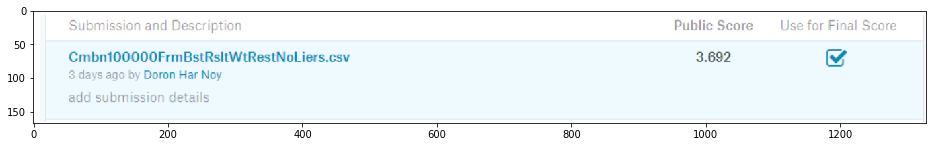

In [236]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(16,9))
img=mpimg.imread('./Pics/100000.PNG')
imgplot = plt.imshow(img)
plt.show()

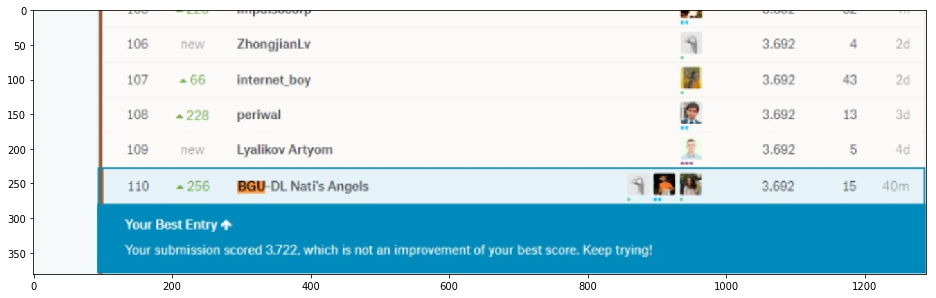

In [238]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(16,9))
img=mpimg.imread('./Pics/LBPNG.PNG')
imgplot = plt.imshow(img)
plt.show()

## Failed attempts (Including embeddings, stay tuned)

## Try with weighted average

Another idea was to combine between models by the number of outliers found in every decile. <br>
This is what we've found in the data set sorted from least likely outlier to most likely outlier:

decile,     numberOfOutliers <br>
0-20   ,    0<br>
20-40   ,   5<br>
40-60    ,  11<br>
60-80     , 25 <br>
80-100   ,  40<br>
100-120    , 57<br>
120-140    , 91  <br>
140-160    , 138  <br>
160-180    , 280  <br>
180-202    , 1559  <br>


We decided to combine values for the first 20% of the values and use values from model2 (trained without outliers) for the rest 80%. then see where this method could take us

In [204]:
outlier_id = pd.DataFrame(df_outlier_prob.sort_values(by='target',ascending = False))

In [207]:
outlier_id['sort'] = outlier_id['target'] 

In [208]:
del outlier_id['target']

In [209]:
most_likely_liers = best_submission.merge(outlier_id,how='right')

In [211]:
most_likely_liers = most_likely_liers.sort_values(by='sort',ascending = False)

In [213]:
best_submission = pd.read_csv('./Submissions/LastAinSubBaseForOutlier.csv')
model_without_outliers = pd.read_csv('./Submissions/SubBlendLGBNoOutliers.csv')

In [217]:
Percent10 = int(len(most_likely_liers)*0.1)
most_likely_liers10 = most_likely_liers[:Percent10]

In [221]:
%%time
for card_id in most_likely_liers10['card_id']:
    model_without_outliers.loc[model_without_outliers['card_id']==card_id,'target'] = (most_likely_liers10.loc[most_likely_liers10['card_id']==card_id,'target'].values) * 0.7 + (model_without_outliers.loc[model_without_outliers['card_id']==card_id,'target'] )*0.3

Wall time: 6min 42s


In [222]:
most_likely_liers20 = most_likely_liers[Percent10:Percent10*2]

In [224]:
%%time
for card_id in most_likely_liers20['card_id']:
    model_without_outliers.loc[model_without_outliers['card_id']==card_id,'target'] = (most_likely_liers20.loc[most_likely_liers20['card_id']==card_id,'target'].values) * 0.13  + (model_without_outliers.loc[model_without_outliers['card_id']==card_id,'target'] )*0.87

Wall time: 6min 48s


In [225]:
model_without_outliers.to_csv(f'./Submissions/WeightedAverageForFirst20ByPerInOut.csv', index=False)

This method yeilds worse result then model1 alone:

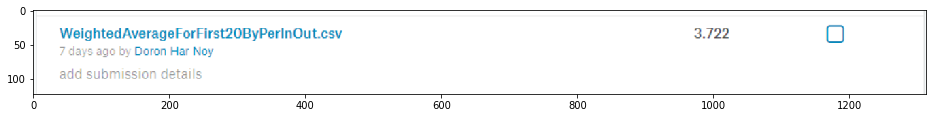

In [240]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(16,9))
img=mpimg.imread('./Pics/Failed1.PNG')
imgplot = plt.imshow(img)
plt.show()

## Try with embeddings in model3 to classify outlier

Idea: run a couple of folds each contains new blend of outliers with ordinary data in even numbers then take mean of results from all folds and try to find the ones that most of the models agree on


In [ ]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical

features = ['feature_3', 'new_month_lag_min', 'new_month_lag_max', 'feature_2', 'feature_1', 'hist_state_id_nunique',
                'auth_installments_min', 'auth_purchase_month_max', 'auth_purchase_month_min', 'hist_purchase_month_max',
                'hist_purchase_month_min', 'auth_month_lag_max', 'new_purchase_month_max', 'new_purchase_month_min',
                'auth_month_lag_min', 'new_state_id_nunique', 'hist_month_lag_min', 'hist_month_lag_max', 'auth_installments_max',
                'new_installments_min', 'hist_installments_max', 'hist_installments_min', 'new_installments_max', 'new_category_1_sum',
                'hist_city_id_nunique', 'auth_state_id_nunique', 'hist_subsector_id_nunique', 'new_subsector_id_nunique', 
                'new_city_id_nunique', 'hist_merchant_category_id_nunique', 'auth_subsector_id_nunique', 'new_merchant_category_id_nunique', 
                'auth_category_3_A_mean', 'hist_merchant_id_nunique', 'auth_city_id_nunique', 'elapsed_time',
                'new_transactions_count', 'new_merchant_id_nunique', 'auth_merchant_category_id_nunique', 'new_installments_sum', 
                'hist_category_1_sum', 'hist_transactions_count', 'new_category_1_mean', 'new_category_3_A_mean', 'month_lag_mean',
                'auth_merchant_id_nunique', 'auth_category_1_sum', 'new_category_3_C_mean']

lenTrain = int(len(train_new_train) *0.8)
lenOutliers = int(len(outliers) *0.8)

newTrainLimit = lenOutliers

for i in range(87):
    x = concatenate([feature_3_emb,new_month_lag_min_emb,new_month_lag_max_emb,feature_2_emb,feature_1_emb,hist_state_id_nunique_emb,auth_installments_min_emb,auth_purchase_month_max_emb,auth_purchase_month_min_emb,hist_purchase_month_max_emb,hist_purchase_month_min_emb,auth_month_lag_max_emb,new_purchase_month_max_emb,new_purchase_month_min_emb,auth_month_lag_min_emb,new_state_id_nunique_emb,hist_month_lag_min_emb,hist_month_lag_max_emb,auth_installments_max_emb,new_installments_min_emb,hist_installments_max_emb,hist_installments_min_emb,new_installments_max_emb,new_category_1_sum_emb,hist_city_id_nunique_emb,auth_state_id_nunique_emb,hist_subsector_id_nunique_emb,new_subsector_id_nunique_emb,new_city_id_nunique_emb,hist_merchant_category_id_nunique_emb,auth_subsector_id_nunique_emb,new_merchant_category_id_nunique_emb,auth_category_3_A_mean_emb,hist_merchant_id_nunique_emb,auth_city_id_nunique_emb,elapsed_time_emb,new_transactions_count_emb,new_merchant_id_nunique_emb,auth_merchant_category_id_nunique_emb,new_installments_sum_emb,hist_category_1_sum_emb,hist_transactions_count_emb,new_category_1_mean_emb,new_category_3_A_mean_emb,month_lag_mean_emb,auth_merchant_id_nunique_emb,auth_category_1_sum_emb,new_category_3_C_mean_emb])

    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dense(10,activation='relu',kernel_initializer='uniform')(x)
    x = Dense(10,activation='relu',kernel_initializer='uniform')(x)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)
    x = Dense(10,activation='relu',kernel_initializer='uniform')(x)
    x = Dense(10,activation='relu',kernel_initializer='uniform')(x)
    x = Dropout(0.7)(x)
    x = Dense(2,activation='softmax',kernel_initializer='uniform')(x)

    model = Model([feature_3_in,new_month_lag_min_in,new_month_lag_max_in,feature_2_in,feature_1_in,hist_state_id_nunique_in,auth_installments_min_in,auth_purchase_month_max_in,auth_purchase_month_min_in,hist_purchase_month_max_in,hist_purchase_month_min_in,auth_month_lag_max_in,new_purchase_month_max_in,new_purchase_month_min_in,auth_month_lag_min_in,new_state_id_nunique_in,hist_month_lag_min_in,hist_month_lag_max_in,auth_installments_max_in,new_installments_min_in,hist_installments_max_in,hist_installments_min_in,new_installments_max_in,new_category_1_sum_in,hist_city_id_nunique_in,auth_state_id_nunique_in,hist_subsector_id_nunique_in,new_subsector_id_nunique_in,new_city_id_nunique_in,hist_merchant_category_id_nunique_in,auth_subsector_id_nunique_in,new_merchant_category_id_nunique_in,auth_category_3_A_mean_in,hist_merchant_id_nunique_in,auth_city_id_nunique_in,elapsed_time_in,new_transactions_count_in,new_merchant_id_nunique_in,auth_merchant_category_id_nunique_in,new_installments_sum_in,hist_category_1_sum_in,hist_transactions_count_in,new_category_1_mean_in,new_category_3_A_mean_in,month_lag_mean_in,auth_merchant_id_nunique_in,auth_category_1_sum_in,new_category_3_C_mean_in], x)
    
#     model.compile(Adam(0.001), loss='categorical_crossentropy')
    model.compile(loss = 'categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])
    
    x_train = (train_new_train[newTrainLimit*i:newTrainLimit*(i+1)] ).append(outliers[:lenOutliers] )
    y_train = train_new_train[['target']][newTrainLimit*i:newTrainLimit*(i+1)].append(outliers[['target']][:lenOutliers])
    if i == 0 : 
        x_val= (train_new_train[newTrainLimit:]).append(outliers[lenOutliers:] )
        y_val = train_new_train[['target']][newTrainLimit:].append(outliers[['target']][lenOutliers:])
    else:
        x_val= (train_new_train[:newTrainLimit*i]).append(train_new_train[newTrainLimit*(i+1):]).append(outliers[lenOutliers:] )
        y_val = train_new_train[['target']][:newTrainLimit*i].append(train_new_train[['target']][newTrainLimit*(i+1):]).append(outliers[['target']][lenOutliers:])
        

    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    checkpointer = ModelCheckpoint(filepath=f'saved_models/weights.embeddingToLoyalityRunNum{i}.df5', 
                                   verbose=1, save_best_only=True)

Idea: using class weight of 10000 to 1 for outlier

In [ ]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical

features = ['feature_3', 'new_month_lag_min', 'new_month_lag_max', 'feature_2', 'feature_1', 'hist_state_id_nunique',
                'auth_installments_min', 'auth_purchase_month_max', 'auth_purchase_month_min', 'hist_purchase_month_max',
                'hist_purchase_month_min', 'auth_month_lag_max', 'new_purchase_month_max', 'new_purchase_month_min',
                'auth_month_lag_min', 'new_state_id_nunique', 'hist_month_lag_min', 'hist_month_lag_max', 'auth_installments_max',
                'new_installments_min', 'hist_installments_max', 'hist_installments_min', 'new_installments_max', 'new_category_1_sum',
                'hist_city_id_nunique', 'auth_state_id_nunique', 'hist_subsector_id_nunique', 'new_subsector_id_nunique', 
                'new_city_id_nunique', 'hist_merchant_category_id_nunique', 'auth_subsector_id_nunique', 'new_merchant_category_id_nunique', 
                'auth_category_3_A_mean', 'hist_merchant_id_nunique', 'auth_city_id_nunique', 'elapsed_time',
                'new_transactions_count', 'new_merchant_id_nunique', 'auth_merchant_category_id_nunique', 'new_installments_sum', 
                'hist_category_1_sum', 'hist_transactions_count', 'new_category_1_mean', 'new_category_3_A_mean', 'month_lag_mean',
                'auth_merchant_id_nunique', 'auth_category_1_sum', 'new_category_3_C_mean']

lenTrain = int(len(train_new_train) *0.8)
lenOutliers = int(len(outliers) *0.8)

newTrainLimit = lenTrain

x_train = (train_new_train[:newTrainLimit] ).append(outliers[:lenOutliers] )
y_train = train_new_train[['target']][:newTrainLimit].append(outliers[['target']][:lenOutliers])
x_val= (train_new_train[newTrainLimit:]).append(outliers[lenOutliers:] )
y_val = train_new_train[['target']][newTrainLimit:].append(outliers[['target']][lenOutliers:])



x = concatenate([feature_3_emb,new_month_lag_min_emb,new_month_lag_max_emb,feature_2_emb,feature_1_emb,hist_state_id_nunique_emb,auth_installments_min_emb,auth_purchase_month_max_emb,auth_purchase_month_min_emb,hist_purchase_month_max_emb,hist_purchase_month_min_emb,auth_month_lag_max_emb,new_purchase_month_max_emb,new_purchase_month_min_emb,auth_month_lag_min_emb,new_state_id_nunique_emb,hist_month_lag_min_emb,hist_month_lag_max_emb,auth_installments_max_emb,new_installments_min_emb,hist_installments_max_emb,hist_installments_min_emb,new_installments_max_emb,new_category_1_sum_emb,hist_city_id_nunique_emb,auth_state_id_nunique_emb,hist_subsector_id_nunique_emb,new_subsector_id_nunique_emb,new_city_id_nunique_emb,hist_merchant_category_id_nunique_emb,auth_subsector_id_nunique_emb,new_merchant_category_id_nunique_emb,auth_category_3_A_mean_emb,hist_merchant_id_nunique_emb,auth_city_id_nunique_emb,elapsed_time_emb,new_transactions_count_emb,new_merchant_id_nunique_emb,auth_merchant_category_id_nunique_emb,new_installments_sum_emb,hist_category_1_sum_emb,hist_transactions_count_emb,new_category_1_mean_emb,new_category_3_A_mean_emb,month_lag_mean_emb,auth_merchant_id_nunique_emb,auth_category_1_sum_emb,new_category_3_C_mean_emb])

x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(10,activation='relu',kernel_initializer='uniform')(x)
x = Dense(10,activation='relu',kernel_initializer='uniform')(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(10,activation='relu',kernel_initializer='uniform')(x)
x = Dense(10,activation='relu',kernel_initializer='uniform')(x)
x = Dropout(0.7)(x)
x = Dense(2,activation='softmax',kernel_initializer='uniform')(x)

model = Model([feature_3_in,new_month_lag_min_in,new_month_lag_max_in,feature_2_in,feature_1_in,hist_state_id_nunique_in,auth_installments_min_in,auth_purchase_month_max_in,auth_purchase_month_min_in,hist_purchase_month_max_in,hist_purchase_month_min_in,auth_month_lag_max_in,new_purchase_month_max_in,new_purchase_month_min_in,auth_month_lag_min_in,new_state_id_nunique_in,hist_month_lag_min_in,hist_month_lag_max_in,auth_installments_max_in,new_installments_min_in,hist_installments_max_in,hist_installments_min_in,new_installments_max_in,new_category_1_sum_in,hist_city_id_nunique_in,auth_state_id_nunique_in,hist_subsector_id_nunique_in,new_subsector_id_nunique_in,new_city_id_nunique_in,hist_merchant_category_id_nunique_in,auth_subsector_id_nunique_in,new_merchant_category_id_nunique_in,auth_category_3_A_mean_in,hist_merchant_id_nunique_in,auth_city_id_nunique_in,elapsed_time_in,new_transactions_count_in,new_merchant_id_nunique_in,auth_merchant_category_id_nunique_in,new_installments_sum_in,hist_category_1_sum_in,hist_transactions_count_in,new_category_1_mean_in,new_category_3_A_mean_in,month_lag_mean_in,auth_merchant_id_nunique_in,auth_category_1_sum_in,new_category_3_C_mean_in], x)

#     model.compile(Adam(0.001), loss='categorical_crossentropy')
model.compile(loss = 'categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=20)

checkpointer = ModelCheckpoint(filepath=f'saved_models/weights.embeddingToLoyalityAllDataWtClassWeight.df5', 
                               verbose=1, save_best_only=True)

class_weight = {0: 10000.,
                1: 1.}

model.fit([x_train[f] for f in features], to_categorical(y_train), batch_size=64,
          epochs=200,
          validation_data=[[x_val[f] for f in features], to_categorical(y_val)], 
          callbacks=[checkpointer,early_stopping],
          class_weight = class_weight  
         )

Made the model classify all as outliers

Idea: using class weight of 100 to 1 for outlier, which is more close to the percent of outliers in data

In [ ]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical

features = ['feature_3', 'new_month_lag_min', 'new_month_lag_max', 'feature_2', 'feature_1', 'hist_state_id_nunique',
                'auth_installments_min', 'auth_purchase_month_max', 'auth_purchase_month_min', 'hist_purchase_month_max',
                'hist_purchase_month_min', 'auth_month_lag_max', 'new_purchase_month_max', 'new_purchase_month_min',
                'auth_month_lag_min', 'new_state_id_nunique', 'hist_month_lag_min', 'hist_month_lag_max', 'auth_installments_max',
                'new_installments_min', 'hist_installments_max', 'hist_installments_min', 'new_installments_max', 'new_category_1_sum',
                'hist_city_id_nunique', 'auth_state_id_nunique', 'hist_subsector_id_nunique', 'new_subsector_id_nunique', 
                'new_city_id_nunique', 'hist_merchant_category_id_nunique', 'auth_subsector_id_nunique', 'new_merchant_category_id_nunique', 
                'auth_category_3_A_mean', 'hist_merchant_id_nunique', 'auth_city_id_nunique', 'elapsed_time',
                'new_transactions_count', 'new_merchant_id_nunique', 'auth_merchant_category_id_nunique', 'new_installments_sum', 
                'hist_category_1_sum', 'hist_transactions_count', 'new_category_1_mean', 'new_category_3_A_mean', 'month_lag_mean',
                'auth_merchant_id_nunique', 'auth_category_1_sum', 'new_category_3_C_mean']

lenTrain = int(len(train_new_train) *0.8)
lenOutliers = int(len(outliers) *0.8)

newTrainLimit = lenTrain

x_train = (train_new_train[:newTrainLimit] ).append(outliers[:lenOutliers] )
y_train = train_new_train[['target']][:newTrainLimit].append(outliers[['target']][:lenOutliers])
x_val= (train_new_train[newTrainLimit:]).append(outliers[lenOutliers:] )
y_val = train_new_train[['target']][newTrainLimit:].append(outliers[['target']][lenOutliers:])



x = concatenate([feature_3_emb,new_month_lag_min_emb,new_month_lag_max_emb,feature_2_emb,feature_1_emb,hist_state_id_nunique_emb,auth_installments_min_emb,auth_purchase_month_max_emb,auth_purchase_month_min_emb,hist_purchase_month_max_emb,hist_purchase_month_min_emb,auth_month_lag_max_emb,new_purchase_month_max_emb,new_purchase_month_min_emb,auth_month_lag_min_emb,new_state_id_nunique_emb,hist_month_lag_min_emb,hist_month_lag_max_emb,auth_installments_max_emb,new_installments_min_emb,hist_installments_max_emb,hist_installments_min_emb,new_installments_max_emb,new_category_1_sum_emb,hist_city_id_nunique_emb,auth_state_id_nunique_emb,hist_subsector_id_nunique_emb,new_subsector_id_nunique_emb,new_city_id_nunique_emb,hist_merchant_category_id_nunique_emb,auth_subsector_id_nunique_emb,new_merchant_category_id_nunique_emb,auth_category_3_A_mean_emb,hist_merchant_id_nunique_emb,auth_city_id_nunique_emb,elapsed_time_emb,new_transactions_count_emb,new_merchant_id_nunique_emb,auth_merchant_category_id_nunique_emb,new_installments_sum_emb,hist_category_1_sum_emb,hist_transactions_count_emb,new_category_1_mean_emb,new_category_3_A_mean_emb,month_lag_mean_emb,auth_merchant_id_nunique_emb,auth_category_1_sum_emb,new_category_3_C_mean_emb])

x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(10,activation='relu',kernel_initializer='uniform')(x)
x = Dense(10,activation='relu',kernel_initializer='uniform')(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(10,activation='relu',kernel_initializer='uniform')(x)
x = Dense(10,activation='relu',kernel_initializer='uniform')(x)
x = Dropout(0.7)(x)
x = Dense(2,activation='softmax',kernel_initializer='uniform')(x)

model = Model([feature_3_in,new_month_lag_min_in,new_month_lag_max_in,feature_2_in,feature_1_in,hist_state_id_nunique_in,auth_installments_min_in,auth_purchase_month_max_in,auth_purchase_month_min_in,hist_purchase_month_max_in,hist_purchase_month_min_in,auth_month_lag_max_in,new_purchase_month_max_in,new_purchase_month_min_in,auth_month_lag_min_in,new_state_id_nunique_in,hist_month_lag_min_in,hist_month_lag_max_in,auth_installments_max_in,new_installments_min_in,hist_installments_max_in,hist_installments_min_in,new_installments_max_in,new_category_1_sum_in,hist_city_id_nunique_in,auth_state_id_nunique_in,hist_subsector_id_nunique_in,new_subsector_id_nunique_in,new_city_id_nunique_in,hist_merchant_category_id_nunique_in,auth_subsector_id_nunique_in,new_merchant_category_id_nunique_in,auth_category_3_A_mean_in,hist_merchant_id_nunique_in,auth_city_id_nunique_in,elapsed_time_in,new_transactions_count_in,new_merchant_id_nunique_in,auth_merchant_category_id_nunique_in,new_installments_sum_in,hist_category_1_sum_in,hist_transactions_count_in,new_category_1_mean_in,new_category_3_A_mean_in,month_lag_mean_in,auth_merchant_id_nunique_in,auth_category_1_sum_in,new_category_3_C_mean_in], x)

#     model.compile(Adam(0.001), loss='categorical_crossentropy')
model.compile(loss = 'categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=20)

checkpointer = ModelCheckpoint(filepath=f'saved_models/weights.embeddingToLoyalityAllDataWtClassWeight100.df5', 
                               verbose=1, save_best_only=True)

class_weight = {0: 100.,
                1: 1.}

model.fit([x_train[f] for f in features], to_categorical(y_train), batch_size=64,
          epochs=200,
          validation_data=[[x_val[f] for f in features], to_categorical(y_val)], 
          callbacks=[checkpointer,early_stopping],
          class_weight = class_weight  
         )

Result: The model did predicted some outliers but also predicted much more non outliers as outliers

In [23]:
unique, counts = np.unique(ClassPredictions, return_counts=True)
dict(zip(unique, counts))

{0: 5602, 1: 34782}

In [27]:
import seaborn as sns

conf = confusion_matrix(y_val, ClassPredictions)

# plt.figure(figsize=(5,5))
# sns.heatmap(data = conf,cmap='RdBu')
conf

array([[  292,   150],
       [ 5310, 34632]], dtype=int64)

Idea: Find the best threshold for classifying outliers with : <br>
predictions[:,1]> threshold instead of argmax 

Result: we couldnt find a threshold in which the model had more good outlier predictions then false positives

# Embedding only Models

## Simple Embedding DL regressor

For start Lets create Embeddings for the categorical features we got in train csv file

In [43]:
from keras.layers import *
from keras.regularizers import l2
from keras.models import Model
from keras.optimizers import Adam

# %reload_ext autoreload
# %autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline
from operator import itemgetter

First Lets normalize our data, normalizing will help the embedding created to better represent relations between features and address them evenly.

In [50]:
print(train.feature_1.describe())

mean1 = np.mean(train['feature_1'])
std1 = np.std(train['feature_1'])
print(f'old mean: {mean1}, old std: {std1}')

print(train.feature_2.describe())

mean2 = np.mean(train['feature_2'])
std2 = np.std(train['feature_2'])
print(f'old mean: {mean2}, old std: {std2}')


print(train.feature_3.describe())

mean3 = np.mean(train['feature_3'])
std3 = np.std(train['feature_3'])
print(f'old mean: {mean3}, old std: {std3}')



count    201917.000000
mean          3.105311
std           1.186160
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           5.000000
Name: feature_1, dtype: float64
old mean: 3.105310597918947, old std: 1.1861566476868783
count    201917.000000
mean          1.745410
std           0.751362
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max           3.000000
Name: feature_2, dtype: float64
old mean: 1.745410242822546, old std: 0.751359875741333
count    201917.000000
mean          0.565569
std           0.495683
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: feature_3, dtype: float64
old mean: 0.5655690209343444, old std: 0.49568205887817995


In [51]:
#normalize data
normalizeFeature1 = (train['feature_1']-mean1)/std1
normalizeFeature2 = (train['feature_2']-mean2)/std2
normalizeFeature3 = (train['feature_3']-mean3)/std3

train['feature_1'] = normalizeFeature1
train['feature_2'] = normalizeFeature2
train['feature_3'] = normalizeFeature3


print(train.feature_1.describe())
print(train.feature_2.describe())
print(train.feature_3.describe())

count    2.019170e+05
mean    -1.152115e-16
std      1.000002e+00
min     -1.774901e+00
25%     -9.318420e-01
50%     -8.878304e-02
75%      7.542759e-01
max      1.597335e+00
Name: feature_1, dtype: float64
count    2.019170e+05
mean    -6.181096e-17
std      1.000002e+00
min     -9.920815e-01
25%     -9.920815e-01
50%      3.388386e-01
75%      3.388386e-01
max      1.669759e+00
Name: feature_2, dtype: float64
count    2.019170e+05
mean    -7.319487e-17
std      1.000002e+00
min     -1.140992e+00
25%     -1.140992e+00
50%      8.764307e-01
75%      8.764307e-01
max      8.764307e-01
Name: feature_3, dtype: float64


In [54]:
print(train.target.describe())

meant = np.mean(train['target'])
stdt = np.std(train['target'])
print(f'old mean: {mean1}, old std: {std1}')


count    201917.000000
mean         -0.393636
std           3.850500
min         -33.219281
25%          -0.883110
50%          -0.023437
75%           0.765453
max          17.965068
Name: target, dtype: float64
old mean: -0.3936362990779874, old std: 3.8504904606159247


In [55]:
normalizet = (train['target']-meant)/stdt

train['target'] = normalizet

print(train.target.describe())

count    2.019170e+05
mean     2.322530e-18
std      1.000002e+00
min     -8.525055e+00
25%     -1.271199e-01
50%      9.614344e-02
75%      3.010238e-01
max      4.767887e+00
Name: target, dtype: float64


Lets visualize again the data

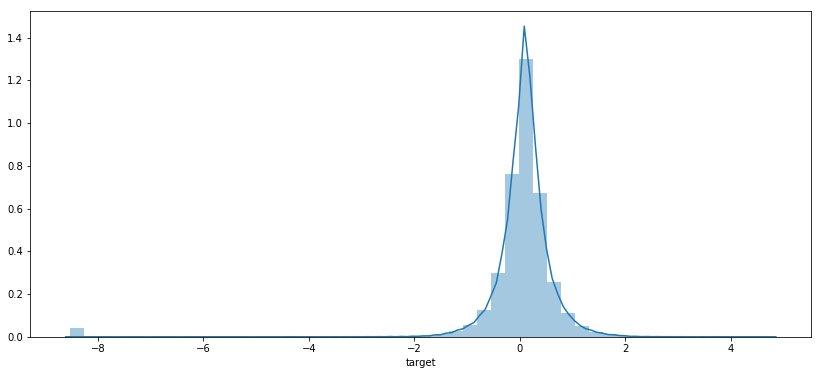

In [56]:
#histogram
f, ax = plt.subplots(figsize=(14, 6))
sns.distplot(train['target'])

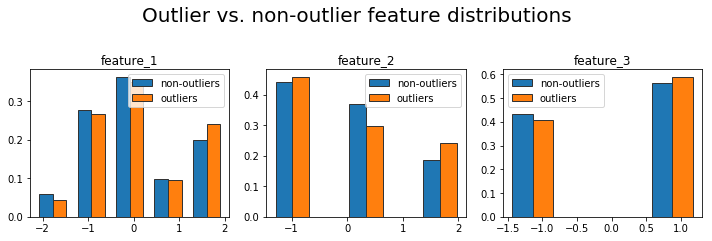

In [64]:
outliers = train.loc[train['target']< -8]

non_outliers = train.loc[train['target'] >= -8]

plt.figure(figsize=[10,5])
plt.suptitle('Outlier vs. non-outlier feature distributions', fontsize=20, y=1.1)

for num, col in enumerate(['feature_1', 'feature_2', 'feature_3']):
    plt.subplot(2, 3, num+1)
    v_c = non_outliers[col].value_counts() / non_outliers.shape[0]
    plt.bar(v_c.index, v_c, label=('non-outliers'), align='edge', width=-0.3, edgecolor=[0.2]*3)
    v_c = outliers[col].value_counts() / outliers.shape[0]
    plt.bar(v_c.index, v_c, label=('outliers'), align='edge', width=0.3, edgecolor=[0.2]*3)
    plt.title(col)
    plt.legend()

plt.tight_layout()
plt.show()



Done normalizing. Lets Create the embedding model

In [66]:
n_feature_3 = train.feature_3.nunique()
n_feature_2 = train.feature_2.nunique()
n_feature_1 = train.feature_1.nunique()

n_factors = 3

In [67]:
feature_3_in = Input(shape=(1,))
feature_3_emb = Embedding(n_feature_3, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(feature_3_in)
feature_2_in = Input(shape=(1,))
feature_2_emb = Embedding(n_feature_2, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(feature_2_in)
feature_1_in = Input(shape=(1,))
feature_1_emb = Embedding(n_feature_1, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(feature_1_in)


In [79]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical

features = ['feature_3', 'feature_2', 'feature_1']

lenTrain = int(len(train) *0.8)
lenOutliers = int(len(outliers) *0.8)

newTrainLimit = lenTrain

x = concatenate([feature_3_emb,feature_2_emb,feature_1_emb])

x = Flatten()(x)

x = BatchNormalization()(x)
x = Dense(10,activation='relu',kernel_initializer='uniform')(x)
x = Dense(10,activation='relu',kernel_initializer='uniform')(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(10,activation='relu',kernel_initializer='uniform')(x)
x = Dense(10,activation='relu',kernel_initializer='uniform')(x)
x = Dropout(0.7)(x)
x = Dense(1,kernel_initializer='uniform')(x)

model = Model([feature_3_in,feature_2_in,feature_1_in], x)

#     model.compile(Adam(0.001), loss='categorical_crossentropy')
model.compile(loss = 'mse',optimizer='sgd')

outliers = train.loc[train['target']< -8]
non_outliers = train.loc[train['target'] >= -8]
newTrainLimit= int(len(non_outliers) *0.8)
lenOutliers = int(len(outliers) *0.8)

x_train = (non_outliers[:newTrainLimit] ).append(outliers[:lenOutliers] )
y_train = non_outliers[['target']][:newTrainLimit].append(outliers[['target']][:lenOutliers])
x_val= (non_outliers[newTrainLimit:]).append(outliers[lenOutliers:] )
y_val = non_outliers[['target']][newTrainLimit:].append(outliers[['target']][lenOutliers:])

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

checkpointer = ModelCheckpoint(filepath=f'saved_models/embeddingToLoyalityOnlyOrigFeatures.df5', 
                               verbose=1, save_best_only=True)


model.fit([x_train[f] for f in features], y_train, batch_size=64,
          epochs=50,
          validation_data=[[x_val[f] for f in features], y_val], 
          callbacks=[checkpointer,early_stopping]
         )

Train on 163298 samples, validate on 40826 samples
Epoch 1/200
163298/163298 [==============================] - 32s 196us/step - loss: 1.7576 - acc: 0.0000e+00 - val_loss: 1.8040 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 1.80396, saving model to saved_models/embeddingToLoyalityOnlyOrigFeatures.df5
Epoch 2/200
163298/163298 [==============================] - 25s 155us/step - loss: 1.7576 - acc: 0.0000e+00 - val_loss: 1.8032 - val_acc: 0.0000e+00

Epoch 00002: val_loss improved from 1.80396 to 1.80324, saving model to saved_models/embeddingToLoyalityOnlyOrigFeatures.df5
Epoch 3/200
163298/163298 [==============================] - 26s 160us/step - loss: 1.7575 - acc: 0.0000e+00 - val_loss: 1.8032 - val_acc: 0.0000e+00

Epoch 00003: val_loss improved from 1.80324 to 1.80321, saving model to saved_models/embeddingToLoyalityOnlyOrigFeatures.df5
Epoch 4/200
163298/163298 [==============================] - 28s 171us/step - loss: 1.7576 - acc: 0.0000e+00 - val_loss: 1.80

Ok, so we've got val loss of 1.8033, lets check the real rmse for the non normalized values

In [92]:
nonNormalizedTrain = pd.read_csv("./all/train.csv", parse_dates=["first_active_month"])
nonNormalizedOutliers = nonNormalizedTrain.loc[train['target']< -8]

y_valNonNor = nonNormalizedTrain[['target']][newTrainLimit:].append(nonNormalizedOutliers[['target']][lenOutliers:])

model.load_weights('saved_models/embeddingToLoyalityOnlyOrigFeatures.df5')
pred = model.predict([x_val[f] for f in features])

In [97]:
predUnNormalized = (pred *stdt) +meant

print("CV score: {:<8.5f}".format(np.sqrt(mean_squared_error(predUnNormalized, y_valNonNor))))

CV score: 5.17058 


In [108]:
print("CV score: {:<8.5f}".format(np.sqrt(mean_squared_error(np.zeros((len(y_valNonNor))), y_valNonNor))))

CV score: 5.22562 


In [111]:
print(np.unique(predUnNormalized))

[-0.74800634 -0.7479886  -0.7479714  -0.74794364 -0.74791443 -0.74789447
 -0.7478897 ]


Our CV score is very bad (but a bit better then submitting zero for every prediction).<br>
We can also see that the model predict only 7 unique loyalty scores which are very close to each other.

We can say that these 3 features alone doesnt contain good enough signal for predicting loyalty score

## Adding more features to DL regressor with Embedding

We can use the aggregated features we found in transaction files to try to improve our embedding model.<br>
We chose to took the 30 most categorical out of them (the 30 with least amount of unique values)

In [128]:
n_feature_3 = train.feature_3.nunique()
n_new_month_lag_min = train.new_month_lag_min.nunique()
n_new_month_lag_max = train.new_month_lag_max.nunique()
n_feature_2 = train.feature_2.nunique()
n_feature_1 = train.feature_1.nunique()
n_hist_state_id_nunique = train.hist_state_id_nunique.nunique()
n_auth_installments_min = train.auth_installments_min.nunique()
n_auth_purchase_month_max = train.auth_purchase_month_max.nunique()
n_auth_purchase_month_min = train.auth_purchase_month_min.nunique()
n_hist_purchase_month_max = train.hist_purchase_month_max.nunique()
n_hist_purchase_month_min = train.hist_purchase_month_min.nunique()
n_auth_month_lag_max = train.auth_month_lag_max.nunique()
n_new_purchase_month_max = train.new_purchase_month_max.nunique()
n_new_purchase_month_min = train.new_purchase_month_min.nunique()
n_auth_month_lag_min = train.auth_month_lag_min.nunique()
n_new_state_id_nunique = train.new_state_id_nunique.nunique()
n_hist_month_lag_min = train.hist_month_lag_min.nunique()
n_hist_month_lag_max = train.hist_month_lag_max.nunique()
n_auth_installments_max = train.auth_installments_max.nunique()
n_new_installments_min = train.new_installments_min.nunique()
n_hist_installments_max = train.hist_installments_max.nunique()
n_hist_installments_min = train.hist_installments_min.nunique()
n_new_installments_max = train.new_installments_max.nunique()
n_new_category_1_sum = train.new_category_1_sum.nunique()
n_hist_city_id_nunique = train.hist_city_id_nunique.nunique()
n_auth_state_id_nunique = train.auth_state_id_nunique.nunique()
n_hist_subsector_id_nunique = train.hist_subsector_id_nunique.nunique()
n_new_subsector_id_nunique = train.new_subsector_id_nunique.nunique()
n_new_city_id_nunique = train.new_city_id_nunique.nunique()
n_hist_merchant_category_id_nunique = train.hist_merchant_category_id_nunique.nunique()
n_auth_subsector_id_nunique = train.auth_subsector_id_nunique.nunique()
n_new_merchant_category_id_nunique = train.new_merchant_category_id_nunique.nunique()
n_auth_category_3_A_mean = train.auth_category_3_A_mean.nunique()
n_hist_merchant_id_nunique = train.hist_merchant_id_nunique.nunique()
n_auth_city_id_nunique = train.auth_city_id_nunique.nunique()
n_new_transactions_count = train.new_transactions_count.nunique()
n_new_merchant_id_nunique = train.new_merchant_id_nunique.nunique()
n_auth_merchant_category_id_nunique = train.auth_merchant_category_id_nunique.nunique()
n_new_installments_sum = train.new_installments_sum.nunique()
n_hist_category_1_sum = train.hist_category_1_sum.nunique()
n_hist_transactions_count = train.hist_transactions_count.nunique()
n_new_category_1_mean = train.new_category_1_mean.nunique()
n_new_category_3_A_mean = train.new_category_3_A_mean.nunique()
n_month_lag_mean = train.month_lag_mean.nunique()
n_auth_merchant_id_nunique = train.auth_merchant_id_nunique.nunique()
n_auth_category_1_sum = train.auth_category_1_sum.nunique()
n_new_category_3_C_mean = train.new_category_3_C_mean.nunique()


n_factors = 3

In [130]:
feature_3_in = Input(shape=(1,))
feature_3_emb = Embedding(n_feature_3, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(feature_3_in)
new_month_lag_min_in = Input(shape=(1,))
new_month_lag_min_emb = Embedding(n_new_month_lag_min, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(new_month_lag_min_in)
new_month_lag_max_in = Input(shape=(1,))
new_month_lag_max_emb = Embedding(n_new_month_lag_max, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(new_month_lag_max_in)
feature_2_in = Input(shape=(1,))
feature_2_emb = Embedding(n_feature_2, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(feature_2_in)
feature_1_in = Input(shape=(1,))
feature_1_emb = Embedding(n_feature_1, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(feature_1_in)
hist_state_id_nunique_in = Input(shape=(1,))
hist_state_id_nunique_emb = Embedding(n_hist_state_id_nunique, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(hist_state_id_nunique_in)
auth_installments_min_in = Input(shape=(1,))
auth_installments_min_emb = Embedding(n_auth_installments_min, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(auth_installments_min_in)
auth_purchase_month_max_in = Input(shape=(1,))
auth_purchase_month_max_emb = Embedding(n_auth_purchase_month_max, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(auth_purchase_month_max_in)
auth_purchase_month_min_in = Input(shape=(1,))
auth_purchase_month_min_emb = Embedding(n_auth_purchase_month_min, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(auth_purchase_month_min_in)
hist_purchase_month_max_in = Input(shape=(1,))
hist_purchase_month_max_emb = Embedding(n_hist_purchase_month_max, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(hist_purchase_month_max_in)
hist_purchase_month_min_in = Input(shape=(1,))
hist_purchase_month_min_emb = Embedding(n_hist_purchase_month_min, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(hist_purchase_month_min_in)
auth_month_lag_max_in = Input(shape=(1,))
auth_month_lag_max_emb = Embedding(n_auth_month_lag_max, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(auth_month_lag_max_in)
new_purchase_month_max_in = Input(shape=(1,))
new_purchase_month_max_emb = Embedding(n_new_purchase_month_max, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(new_purchase_month_max_in)
new_purchase_month_min_in = Input(shape=(1,))
new_purchase_month_min_emb = Embedding(n_new_purchase_month_min, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(new_purchase_month_min_in)
auth_month_lag_min_in = Input(shape=(1,))
auth_month_lag_min_emb = Embedding(n_auth_month_lag_min, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(auth_month_lag_min_in)
new_state_id_nunique_in = Input(shape=(1,))
new_state_id_nunique_emb = Embedding(n_new_state_id_nunique, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(new_state_id_nunique_in)
hist_month_lag_min_in = Input(shape=(1,))
hist_month_lag_min_emb = Embedding(n_hist_month_lag_min, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(hist_month_lag_min_in)
hist_month_lag_max_in = Input(shape=(1,))
hist_month_lag_max_emb = Embedding(n_hist_month_lag_max, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(hist_month_lag_max_in)
auth_installments_max_in = Input(shape=(1,))
auth_installments_max_emb = Embedding(n_auth_installments_max, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(auth_installments_max_in)
new_installments_min_in = Input(shape=(1,))
new_installments_min_emb = Embedding(n_new_installments_min, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(new_installments_min_in)
hist_installments_max_in = Input(shape=(1,))
hist_installments_max_emb = Embedding(n_hist_installments_max, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(hist_installments_max_in)
hist_installments_min_in = Input(shape=(1,))
hist_installments_min_emb = Embedding(n_hist_installments_min, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(hist_installments_min_in)
new_installments_max_in = Input(shape=(1,))
new_installments_max_emb = Embedding(n_new_installments_max, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(new_installments_max_in)
new_category_1_sum_in = Input(shape=(1,))
new_category_1_sum_emb = Embedding(n_new_category_1_sum, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(new_category_1_sum_in)
hist_city_id_nunique_in = Input(shape=(1,))
hist_city_id_nunique_emb = Embedding(n_hist_city_id_nunique, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(hist_city_id_nunique_in)
auth_state_id_nunique_in = Input(shape=(1,))
auth_state_id_nunique_emb = Embedding(n_auth_state_id_nunique, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(auth_state_id_nunique_in)
hist_subsector_id_nunique_in = Input(shape=(1,))
hist_subsector_id_nunique_emb = Embedding(n_hist_subsector_id_nunique, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(hist_subsector_id_nunique_in)
new_subsector_id_nunique_in = Input(shape=(1,))
new_subsector_id_nunique_emb = Embedding(n_new_subsector_id_nunique, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(new_subsector_id_nunique_in)
new_city_id_nunique_in = Input(shape=(1,))
new_city_id_nunique_emb = Embedding(n_new_city_id_nunique, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(new_city_id_nunique_in)
hist_merchant_category_id_nunique_in = Input(shape=(1,))
hist_merchant_category_id_nunique_emb = Embedding(n_hist_merchant_category_id_nunique, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(hist_merchant_category_id_nunique_in)
auth_subsector_id_nunique_in = Input(shape=(1,))
auth_subsector_id_nunique_emb = Embedding(n_auth_subsector_id_nunique, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(auth_subsector_id_nunique_in)
new_merchant_category_id_nunique_in = Input(shape=(1,))
new_merchant_category_id_nunique_emb = Embedding(n_new_merchant_category_id_nunique, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(new_merchant_category_id_nunique_in)
auth_category_3_A_mean_in = Input(shape=(1,))
auth_category_3_A_mean_emb = Embedding(n_auth_category_3_A_mean, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(auth_category_3_A_mean_in)
hist_merchant_id_nunique_in = Input(shape=(1,))
hist_merchant_id_nunique_emb = Embedding(n_hist_merchant_id_nunique, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(hist_merchant_id_nunique_in)
auth_city_id_nunique_in = Input(shape=(1,))
auth_city_id_nunique_emb = Embedding(n_auth_city_id_nunique, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(auth_city_id_nunique_in)

new_transactions_count_in = Input(shape=(1,))
new_transactions_count_emb = Embedding(n_new_transactions_count, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(new_transactions_count_in)
new_merchant_id_nunique_in = Input(shape=(1,))
new_merchant_id_nunique_emb = Embedding(n_new_merchant_id_nunique, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(new_merchant_id_nunique_in)
auth_merchant_category_id_nunique_in = Input(shape=(1,))
auth_merchant_category_id_nunique_emb = Embedding(n_auth_merchant_category_id_nunique, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(auth_merchant_category_id_nunique_in)
new_installments_sum_in = Input(shape=(1,))
new_installments_sum_emb = Embedding(n_new_installments_sum, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(new_installments_sum_in)
hist_category_1_sum_in = Input(shape=(1,))
hist_category_1_sum_emb = Embedding(n_hist_category_1_sum, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(hist_category_1_sum_in)
hist_transactions_count_in = Input(shape=(1,))
hist_transactions_count_emb = Embedding(n_hist_transactions_count, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(hist_transactions_count_in)
new_category_1_mean_in = Input(shape=(1,))
new_category_1_mean_emb = Embedding(n_new_category_1_mean, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(new_category_1_mean_in)
new_category_3_A_mean_in = Input(shape=(1,))
new_category_3_A_mean_emb = Embedding(n_new_category_3_A_mean, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(new_category_3_A_mean_in)
month_lag_mean_in = Input(shape=(1,))
month_lag_mean_emb = Embedding(n_month_lag_mean, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(month_lag_mean_in)
auth_merchant_id_nunique_in = Input(shape=(1,))
auth_merchant_id_nunique_emb = Embedding(n_auth_merchant_id_nunique, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(auth_merchant_id_nunique_in)
auth_category_1_sum_in = Input(shape=(1,))
auth_category_1_sum_emb = Embedding(n_auth_category_1_sum, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(auth_category_1_sum_in)
new_category_3_C_mean_in = Input(shape=(1,))
new_category_3_C_mean_emb = Embedding(n_new_category_3_C_mean, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(new_category_3_C_mean_in)



In [135]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical

features = ['feature_3', 'new_month_lag_min', 'new_month_lag_max', 'feature_2', 'feature_1', 'hist_state_id_nunique',
                'auth_installments_min', 'auth_purchase_month_max', 'auth_purchase_month_min', 'hist_purchase_month_max',
                'hist_purchase_month_min', 'auth_month_lag_max', 'new_purchase_month_max', 'new_purchase_month_min',
                'auth_month_lag_min', 'new_state_id_nunique', 'hist_month_lag_min', 'hist_month_lag_max', 'auth_installments_max',
                'new_installments_min', 'hist_installments_max', 'hist_installments_min', 'new_installments_max', 'new_category_1_sum',
                'hist_city_id_nunique', 'auth_state_id_nunique', 'hist_subsector_id_nunique', 'new_subsector_id_nunique', 
                'new_city_id_nunique', 'hist_merchant_category_id_nunique', 'auth_subsector_id_nunique', 'new_merchant_category_id_nunique', 
                'auth_category_3_A_mean', 'hist_merchant_id_nunique', 'auth_city_id_nunique',
                'new_transactions_count', 'new_merchant_id_nunique', 'auth_merchant_category_id_nunique', 'new_installments_sum', 
                'hist_category_1_sum', 'hist_transactions_count', 'new_category_1_mean', 'new_category_3_A_mean', 'month_lag_mean',
                'auth_merchant_id_nunique', 'auth_category_1_sum', 'new_category_3_C_mean']

lenTrain = int(len(train) *0.8)
lenOutliers = int(len(outliers) *0.8)

newTrainLimit = lenOutliers


x = concatenate([feature_3_emb,new_month_lag_min_emb,new_month_lag_max_emb,feature_2_emb,feature_1_emb,hist_state_id_nunique_emb,auth_installments_min_emb,auth_purchase_month_max_emb,auth_purchase_month_min_emb,hist_purchase_month_max_emb,hist_purchase_month_min_emb,auth_month_lag_max_emb,new_purchase_month_max_emb,new_purchase_month_min_emb,auth_month_lag_min_emb,new_state_id_nunique_emb,hist_month_lag_min_emb,hist_month_lag_max_emb,auth_installments_max_emb,new_installments_min_emb,hist_installments_max_emb,hist_installments_min_emb,new_installments_max_emb,new_category_1_sum_emb,hist_city_id_nunique_emb,auth_state_id_nunique_emb,hist_subsector_id_nunique_emb,new_subsector_id_nunique_emb,new_city_id_nunique_emb,hist_merchant_category_id_nunique_emb,auth_subsector_id_nunique_emb,new_merchant_category_id_nunique_emb,auth_category_3_A_mean_emb,hist_merchant_id_nunique_emb,auth_city_id_nunique_emb,new_transactions_count_emb,new_merchant_id_nunique_emb,auth_merchant_category_id_nunique_emb,new_installments_sum_emb,hist_category_1_sum_emb,hist_transactions_count_emb,new_category_1_mean_emb,new_category_3_A_mean_emb,month_lag_mean_emb,auth_merchant_id_nunique_emb,auth_category_1_sum_emb,new_category_3_C_mean_emb])

x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(10,activation='relu',kernel_initializer='uniform')(x)
x = Dense(10,activation='relu',kernel_initializer='uniform')(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(10,activation='relu',kernel_initializer='uniform')(x)
x = Dense(10,activation='relu',kernel_initializer='uniform')(x)
x = Dropout(0.7)(x)
x = Dense(1,kernel_initializer='uniform')(x)

model = Model([feature_3_in,new_month_lag_min_in,new_month_lag_max_in,feature_2_in,feature_1_in,hist_state_id_nunique_in,auth_installments_min_in,auth_purchase_month_max_in,auth_purchase_month_min_in,hist_purchase_month_max_in,hist_purchase_month_min_in,auth_month_lag_max_in,new_purchase_month_max_in,new_purchase_month_min_in,auth_month_lag_min_in,new_state_id_nunique_in,hist_month_lag_min_in,hist_month_lag_max_in,auth_installments_max_in,new_installments_min_in,hist_installments_max_in,hist_installments_min_in,new_installments_max_in,new_category_1_sum_in,hist_city_id_nunique_in,auth_state_id_nunique_in,hist_subsector_id_nunique_in,new_subsector_id_nunique_in,new_city_id_nunique_in,hist_merchant_category_id_nunique_in,auth_subsector_id_nunique_in,new_merchant_category_id_nunique_in,auth_category_3_A_mean_in,hist_merchant_id_nunique_in,auth_city_id_nunique_in,new_transactions_count_in,new_merchant_id_nunique_in,auth_merchant_category_id_nunique_in,new_installments_sum_in,hist_category_1_sum_in,hist_transactions_count_in,new_category_1_mean_in,new_category_3_A_mean_in,month_lag_mean_in,auth_merchant_id_nunique_in,auth_category_1_sum_in,new_category_3_C_mean_in], x)

#     model.compile(Adam(0.001), loss='categorical_crossentropy')
model.compile(loss = 'mse',optimizer='sgd')
    
outliers = train.loc[train['target']< -8]
non_outliers = train.loc[train['target'] >= -8]
newTrainLimit= int(len(non_outliers) *0.8)
lenOutliers = int(len(outliers) *0.8)

x_train = (non_outliers[:newTrainLimit] ).append(outliers[:lenOutliers] )
y_train = non_outliers[['target']][:newTrainLimit].append(outliers[['target']][:lenOutliers])
x_val= (non_outliers[newTrainLimit:]).append(outliers[lenOutliers:] )
y_val = non_outliers[['target']][newTrainLimit:].append(outliers[['target']][lenOutliers:])
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

checkpointer = ModelCheckpoint(filepath=f'saved_models/weights.embeddingToLoyality.df5', 
                                   verbose=1, save_best_only=True)

In [136]:
 model.fit([x_train[f] for f in features], y_train, batch_size=64, epochs=50,
              validation_data=[[x_val[f] for f in features], y_val], callbacks=[checkpointer,early_stopping])

Train on 3530 samples, validate on 200594 samples
Epoch 1/50
3530/3530 [==============================] - 30s 8ms/step - loss: 26.0031 - val_loss: 9.9694

Epoch 00001: val_loss improved from inf to 9.96942, saving model to saved_models/weights.embeddingToLoyality.df5
Epoch 2/50
3530/3530 [==============================] - 25s 7ms/step - loss: 17.5806 - val_loss: 11.6921

Epoch 00002: val_loss did not improve from 9.96942
Epoch 3/50
3530/3530 [==============================] - 25s 7ms/step - loss: 10.5530 - val_loss: 3.6191

Epoch 00003: val_loss improved from 9.96942 to 3.61914, saving model to saved_models/weights.embeddingToLoyality.df5
Epoch 4/50
3530/3530 [==============================] - 25s 7ms/step - loss: 9.0365 - val_loss: 4.1736

Epoch 00004: val_loss did not improve from 3.61914
Epoch 5/50
3530/3530 [==============================] - 25s 7ms/step - loss: 8.9625 - val_loss: 3.7029

Epoch 00005: val_loss did not improve from 3.61914
Epoch 6/50
3530/3530 [=====================

In [139]:
model.load_weights('saved_models/weights.embeddingToLoyality.df5')
pred = model.predict([x_val[f] for f in features])

In [ ]:
predUnNormalized = (pred *stdt) +meant

print("CV score: {:<8.5f}".format(np.sqrt(mean_squared_error(predUnNormalized, y_valNonNor))))

In [144]:
print("CV score: {:<8.5f}".format(np.sqrt(mean_squared_error(np.zeros((len(y_valNonNor))), y_valNonNor))))

CV score: 5.22562 


Still no big improvement. 😕

## Embedding as feature extractor

First Lets arrange our train and validation sets

In [194]:
outliers = train.loc[train['target']< -8]
non_outliers = train.loc[train['target'] >= -8]
newTrainLimit= int(len(non_outliers) *0.8)
lenOutliers = int(len(outliers) *0.8)

x_train = (non_outliers[:newTrainLimit] ).append(outliers[:lenOutliers] )
y_train = non_outliers[['target']][:newTrainLimit].append(outliers[['target']][:lenOutliers])
x_val= (non_outliers[newTrainLimit:]).append(outliers[lenOutliers:] )
y_val = non_outliers[['target']][newTrainLimit:].append(outliers[['target']][lenOutliers:])


Creating a feature extractor from model with flatten as output layer

In [207]:
output = model.get_layer("flatten_6").output 
feature_extractor = Model(model.input, output)

In [211]:
trainExtractedFeatures = feature_extractor.predict([x_train[f] for f in features])

In [216]:
from sklearn.linear_model import LinearRegression

linearRegression = LinearRegression()
linearRegression.fit(trainExtractedFeatures, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [220]:
valExtractedFeatures = feature_extractor.predict([x_val[f] for f in features])

In [221]:
preds = linearRegression.predict(valExtractedFeatures)

In [225]:
print("CV score: {:<8.5f}".format(np.sqrt(mean_squared_error(preds, y_val))))

CV score: 0.98411 


Nice! now Lets check CV score for deNormalized

In [227]:
nonNormalizedTrain = pd.read_csv("./all/train.csv", parse_dates=["first_active_month"])

nonNormalizedOutliers = nonNormalizedTrain.loc[train['target']< -8]
nonNormalizedNon_outliers = nonNormalizedTrain.loc[train['target'] >= -8]
newTrainLimit= int(len(nonNormalizedNon_outliers) *0.8)
lenOutliers = int(len(nonNormalizedOutliers) *0.8)

y_valNonNor = nonNormalizedNon_outliers[['target']][newTrainLimit:].append(nonNormalizedOutliers[['target']][lenOutliers:])


In [228]:
predUnNormalized = (preds *stdt) +meant

print("CV score: {:<8.5f}".format(np.sqrt(mean_squared_error(predUnNormalized, y_valNonNor))))

CV score: 3.78929 


Nice improvement, even better then just submitting zeros, but still worse then our best result.

## Trying LGBM for fun

In [230]:
lgbparam = {'num_leaves': 31,
            'boosting_type': 'rf',
             'min_data_in_leaf': 30, 
             'objective':'regression',
             'max_depth': -1,
             'learning_rate': 0.01,
             "min_child_samples": 20,
             "boosting": "gbdt",
             "feature_fraction": 0.9,
             "bagging_freq": 1,
             "bagging_fraction": 0.9 ,
             "bagging_seed": 11,
             "metric": 'rmse',
             "lambda_l1": 0.1,
             "verbosity": -1,
             "nthread": 4,
             "random_state": 4590}

In [246]:
trainExtractedFeatures = feature_extractor.predict([train[f] for f in features])

In [256]:
target = train[['target']]

In [258]:
from sklearn.model_selection import RepeatedKFold
folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4520)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(trainExtractedFeatures, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(trainExtractedFeatures[trn_idx], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(trainExtractedFeatures[val_idx], label=target.iloc[val_idx])

    num_round = 11000
    clf = lgb.train(lgbparam, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    

print("CV score: {:<8.5f}".format(mean_squared_error(oof_lgb, target)**0.5))

fold n°0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.970054	valid_1's rmse: 0.983903
[200]	training's rmse: 0.955259	valid_1's rmse: 0.978601
[300]	training's rmse: 0.944874	valid_1's rmse: 0.976257
[400]	training's rmse: 0.936849	valid_1's rmse: 0.974875
[500]	training's rmse: 0.930045	valid_1's rmse: 0.974157
[600]	training's rmse: 0.923864	valid_1's rmse: 0.973537
[700]	training's rmse: 0.918467	valid_1's rmse: 0.973246
[800]	training's rmse: 0.913769	valid_1's rmse: 0.972923
[900]	training's rmse: 0.909348	valid_1's rmse: 0.972728
[1000]	training's rmse: 0.905219	valid_1's rmse: 0.972549
Early stopping, best iteration is:
[990]	training's rmse: 0.905603	valid_1's rmse: 0.972539
fold n°1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.978427	valid_1's rmse: 0.949651
[200]	training's rmse: 0.963875	valid_1's rmse: 0.943538
[300]	training's rmse: 0.953537	valid_1's rmse: 0.940834
[400]	training's rmse:

In [264]:
predUnNormalized = (oof_lgb *stdt) +meant

print("CV score: {:<8.5f}".format(np.sqrt(mean_squared_error(predUnNormalized, nonNormalizedTrain.target.values))))

CV score: 5.18351 


Nope. 